In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

In [296]:
data = pd.read_csv("../records/log_sac_2020-09-08T19:02:24.394272.csv", sep=";")
data = data[data["Episode"] < 76]
data["Speed"] = np.sqrt(data.SpeedX**2 + data.SpeedY**2 + data.SpeedZ**2)

# Controlling Donkey Car with variable speed 

### Experimental setup

I trained a model where the agent can control the speed of the car as well as the steering. The agent outputs a target speed and a PID controller on the Donkey car controls the throttle such that the speed observed by RealSense matches the desired speed of the agent. The lower bound for speed was 0.25 and upper bound was 0.5 (m/s, I guess).

I didn't change much in the experimental setup from the constant throttle to variable speed. The only major change was that I reduced the control history from 20 steps to 5. I did not include the observed speed of the car to the state, even though that would probably be smart. Instead, I just trusted that speed is inferrable enough from the past 5 controls. I'll probably add that later.

As reward I used 

$r = 1 + \frac{v_{car} - speedLowerBound}{speedUpperBound - speedLowerBound}$,

when car is driving on the track and $-10r$ when it drives of. Here $v_{car}$ is the speed observed by the Realsense.


### Core results

I present here results from my latest and my most successful run with variable speed. I have made runs with constant speed and other runs with variable speed that have not been as succesful. Those runs have, however, have had other issues with them that I fixed for this one but still I should maybe run a few more runs to verify that this actually works this well.

With variable throttle the car is able to learn to navigate the track in 27 episode which was **1400 environment steps** or about 2.5 minutes of driving on the track. On episodes 27 and 28 the car completed perfect episodes of 500 steps or about 4 laps around the track without a fail.

After this I continued training to see how well the car could learn to control the throttle. Over time the average speed of the episodes rose and qualitatively the car was in some cases picking more optimal curves around the track. 

I was not able to run this to completion as the drift in RealSense got to a point where the speed estimate was unrealiable. This was actually so bad that Realsense thought it was travelign at 200 m/s when it reality the car was standing still. This nauturally caused the car to reverse a full speed straigth to a wall. Luckily, this is not a problem as I can reset the RealSense between episodes but should be taken into consideration for applications that require relative positioning between episodes without calibrating in between.

Qualitatively, I feel that the policy is not as stable with variable speed as it was with constant throttle. Including the throttle control probably adds considerable noise to the policy during training compared to a constant throttle. As the car explores the throttle it is at a higher risk of driving out of the track or ending up in a unrecoverable situation. The magnitude of this could be tested for example by training an agent with constant speed and comparing the stability of the policies.

Also, currently I am only evaluating the policy performance while I am training. This means that the actions are sampled from a random distribution provided by the policy. A better way of evaluating perfomance would be to only take the mean of the distribution instead of sampling which should result in the highest performance. I don't know if there are other stability issues with this approach that contribute more e.g. RealSense but trying this would be another option.

## General learning

1000 reward per episode is not exactly the maximum reward as the real speed is used in the reward and that contains noice. However, it is close enough.

The car is able to learn to drive in 27 episodes. After that it still fails frequently, usually due to exploring the throttle.

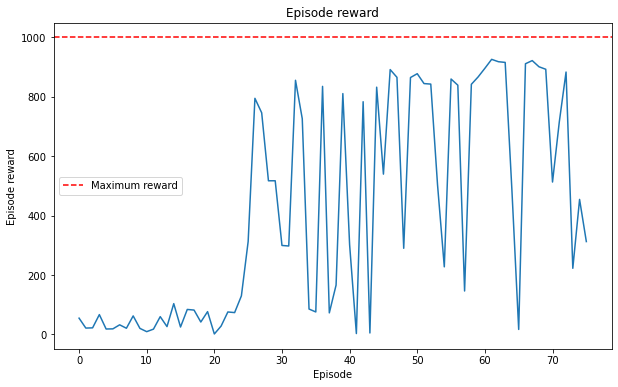

In [307]:
plt.figure(1, (10, 6))
plt.title("Episode reward")
plt.plot(data.groupby("Episode").sum().Reward)
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.axhline(1000, linestyle="--", color="red", label="Maximum reward")
plt.legend()
plt.show()

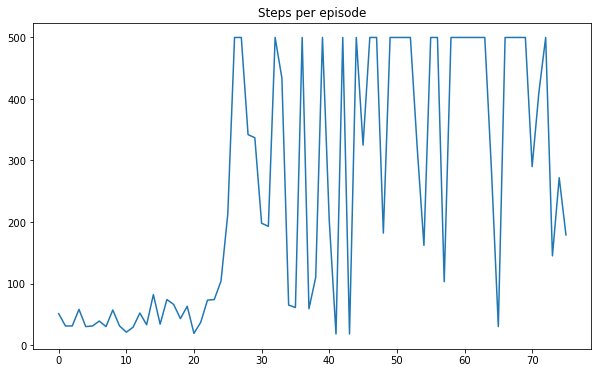

In [314]:
plt.figure(1, (10, 6))
plt.title("Steps per episode")
plt.plot(data.groupby("Episode").max().Step)
plt.show()

### Episodewise average speed improves over time so it seems like the car is learning to drive faster.

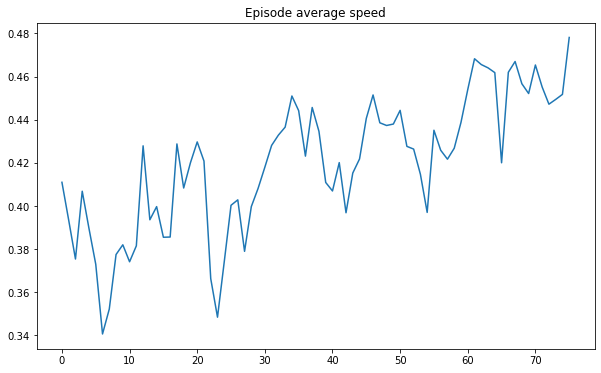

In [315]:
plt.figure(1, (10, 6))
plt.title("Episode average speed")
plt.plot(data[data.Step > 10].groupby("Episode").mean().Speed)
plt.show()

### RealSense Drift on Donkey Car

Due to picking up and setting down the car while resetting, RealSense incurs quite a bit of drift over time since I did not reset it between episodes. 

In this plot are all the individual episode trajectories provided by the RealSense. In this plot the start of each episode is normalized to (0,0) which eliminates translational drift between episodes but the rotational drift is clearly visible.

I also not sure how level my installation of the Realsense is on the car. I am plotting only 2 dimensions ignoring the y-axis and it gives a results that seems about right.

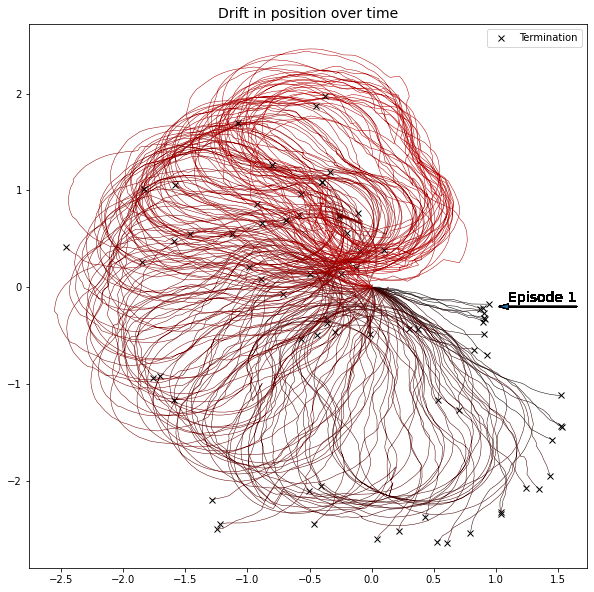

In [310]:
plt.figure(1, (10, 10))
for i in range(data["Episode"].max()):
    episode = data[data.Episode == i]
    x = episode["PosX"].values[5:]
    z = episode["PosZ"].values[5:]

    plt.plot(x - x[0], z - z[0], color=(i / 100, 0, 0), linewidth=0.5)#, linewidth = 0.3 + i / 200)
    plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
    
    #plt.plot(x, z , color=(i / 100, 0, 0), linewidth=0.5)#, linewidth = 0.3 + i / 200)
    #plt.plot(x - x[0], z -# z[0], color = "k")
    
    plt.title("Drift in position over time", size = 14)
    plt.annotate("Episode 1", (1.1, -0.15), size=14)
    plt.arrow(1.65, -0.2, -0.55, 0, head_width=0.05)
    #plt.xlim((-2, 1))
    #plt.ylim((-2, 1.5))
    #plt.show()
    #plt.legend()
    #plt.show()
plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k", label="Termination", linestyle="None")
plt.legend()
plt.show()

### A Closer look on a couple of episodes 

In the beginning the tracking is really smooth but after time there is more and more jitter in the positional data. I don't know what causes this, it could be some automatic loop completion thing as especially in the last one is a huge jump in the position.

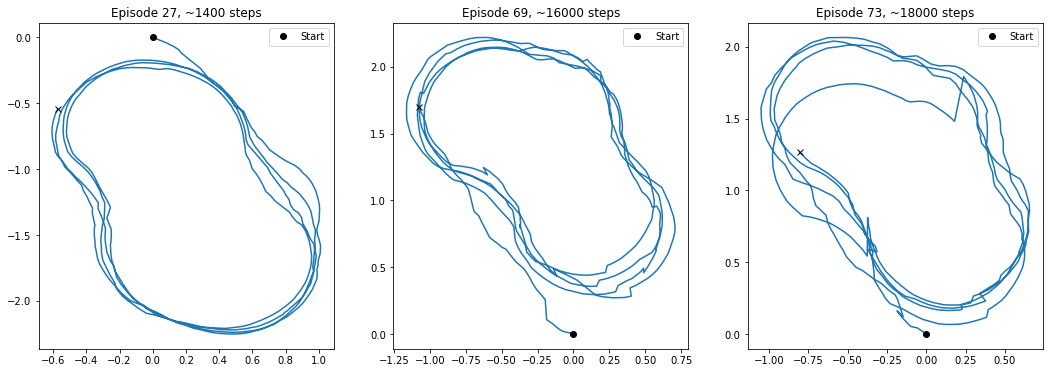

In [263]:
plt.figure(1, (18, 6))
episode = data[data.Episode == 26]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.subplot(1, 3, 1)
plt.plot(x - x[0], z - z[0])
plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
plt.title("Episode {}, ~1400 steps".format(27))

plt.plot(0, 0, marker="o", color="k", label="Start", linestyle="None")
plt.legend()

plt.subplot(1, 3, 2)
e = 68

plt.figure(1, (10, 10))
episode = data[data.Episode == e]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.plot(x - x[0], z - z[0])
plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
plt.plot(0, 0, marker="o", color="k", label="Start", linestyle="None")

plt.title("Episode {}, ~16000 steps".format(e + 1))
plt.legend()

plt.subplot(1, 3, 3)
e = 72

plt.figure(1, (10, 10))
episode = data[data.Episode == e]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.plot(x - x[0], z - z[0])
plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
plt.title("Episode {}, ~18000 steps".format(e + 1))

plt.plot(0, 0, marker="o", color="k", label="Start", linestyle="None")

plt.legend()

plt.show()

### How the car respond to speed commands from the agent

As expected, the speed of the car lags behind the command from the agent by a few steps.

In the lower plot can be seen that over time the speed control of the car smoothens out and the agent has definite points where it want's to slow down and go fast. In the begining of training the speed control is more frantic.

Also, compared to episode 27, on episode 69 there are clearly visible spikes upwards that are not expalained by throttle input. This is noise from the drift of RealSense that causes the PID-controller to adjust throttle incorrectly. This can be a major reason why the policy is not that stable. In episode 27 plot the speed follows the agents output really nicely.

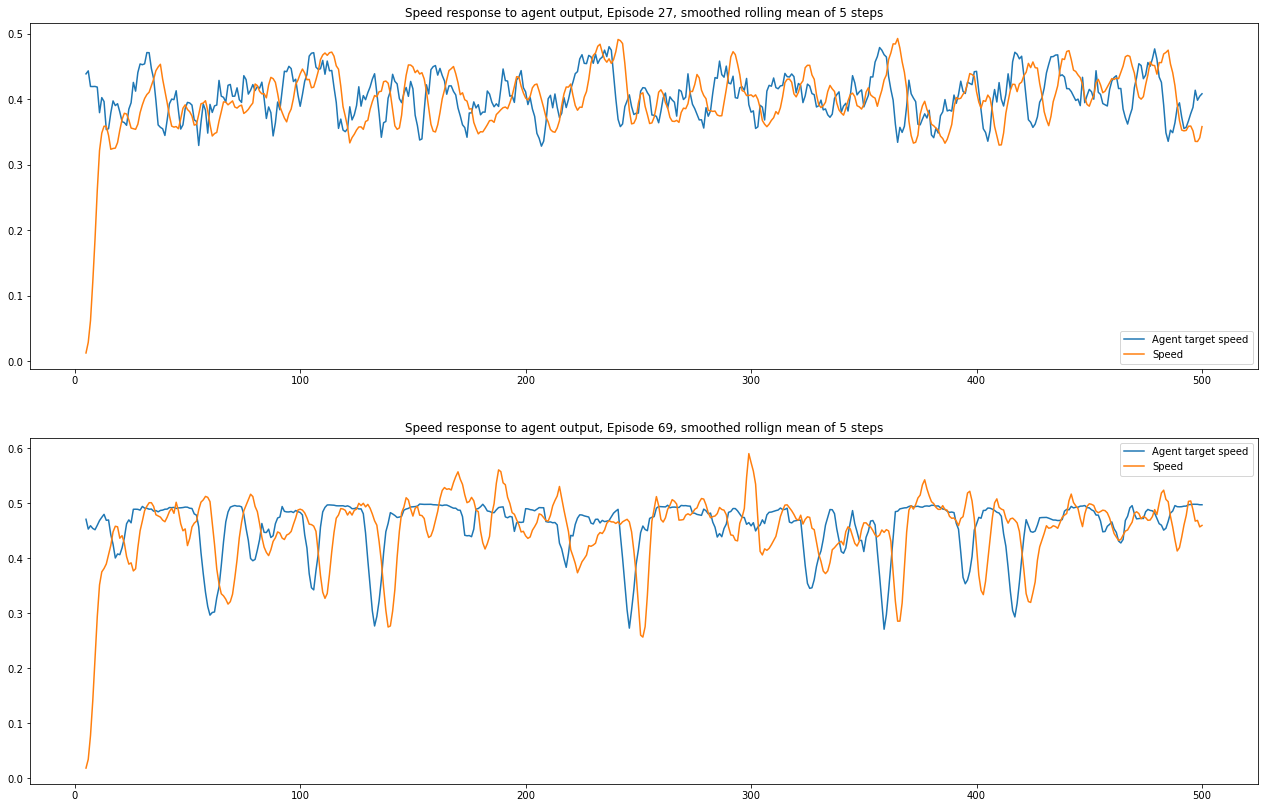

In [311]:
plt.figure(1, (22, 14))
episode = data[data.Episode == 26]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.subplot(2, 1, 1)
plt.plot(episode.Step, (episode.Throttle / 8 + 0.375).rolling(5).mean(), label="Agent target speed")
plt.plot(episode.Step, episode.Speed.rolling(5).mean(), label="Speed")
plt.title("Speed response to agent output, Episode 27, smoothed rolling mean of 5 steps")
plt.legend()

plt.subplot(2, 1, 2)
episode = data[data.Episode == 68]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.plot(episode.Step, (episode.Throttle / 8 + 0.375).rolling(5).mean(), label="Agent target speed")
plt.plot(episode.Step, episode.Speed.rolling(5).mean(), label="Speed")
plt.title("Speed response to agent output, Episode 69, smoothed rollign mean of 5 steps")
plt.legend()

plt.show()

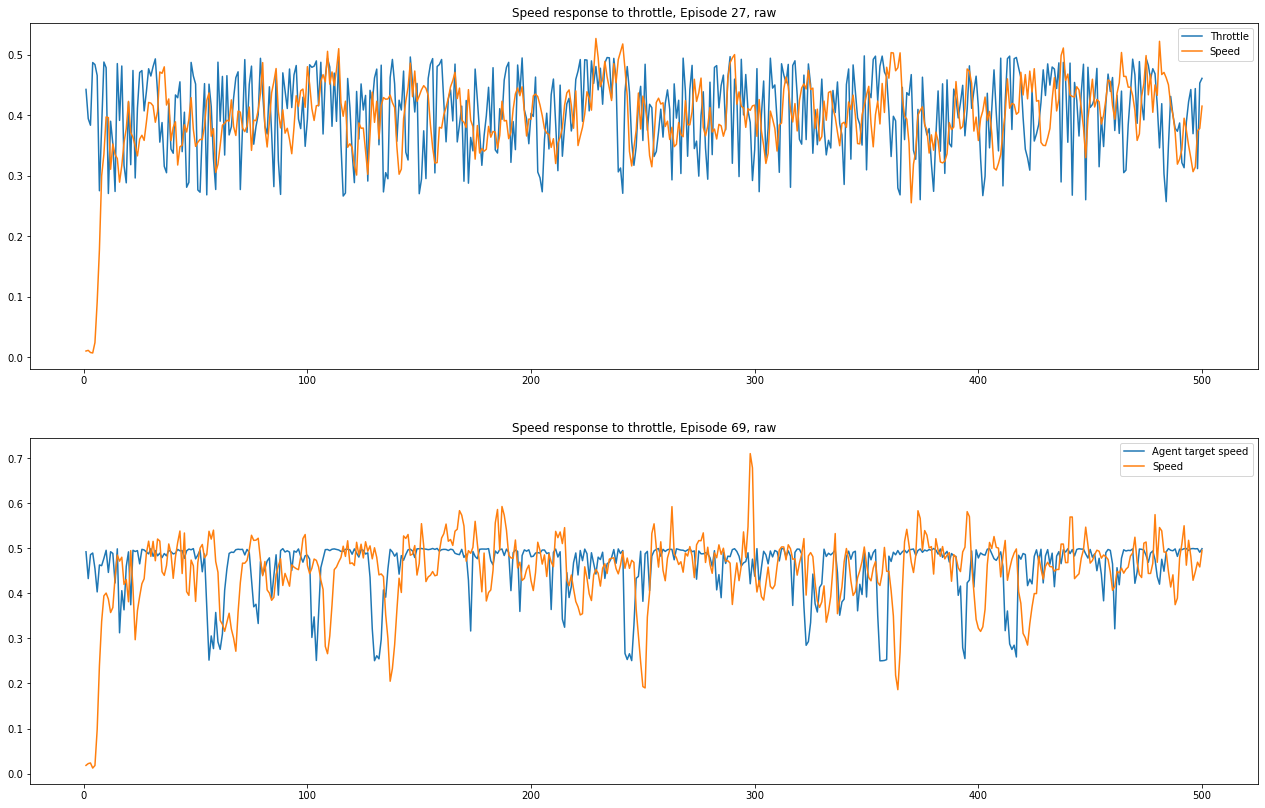

In [265]:
plt.figure(1, (22, 14))


plt.subplot(2, 1, 1)
episode = data[data.Episode == 26]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.plot(episode.Step, (episode.Throttle / 8 + 0.375).rolling(1).mean(), label="Throttle")
plt.plot(episode.Step, episode.Speed.rolling(1).mean(), label="Speed")
plt.title("Speed response to throttle, Episode 27, raw")
plt.legend()

plt.subplot(2, 1, 2)
episode = data[data.Episode == 68]
x = episode["PosX"].values[5:]
z = episode["PosZ"].values[5:]

plt.plot(episode.Step, (episode.Throttle / 8 + 0.375).rolling(1).mean(), label="Agent target speed")
plt.plot(episode.Step, episode.Speed.rolling(1).mean(), label="Speed")
plt.title("Speed response to throttle, Episode 69, raw")
plt.legend()

plt.show()

### Driving behavior

Over time the time the agent learns to drive faster and it also adapts more refined driving trajectories (could also be RealSense drift but I also observed this effect). Like could be seen in the target-speed/speed plots, the trained agent has certain places where it slows down and otherwise it puts the pedal to the metal. The not trained agent is much more cautious and dares to drive fast only on the starting straight and a similar past of track on the other side but takes the large curves more slowly.

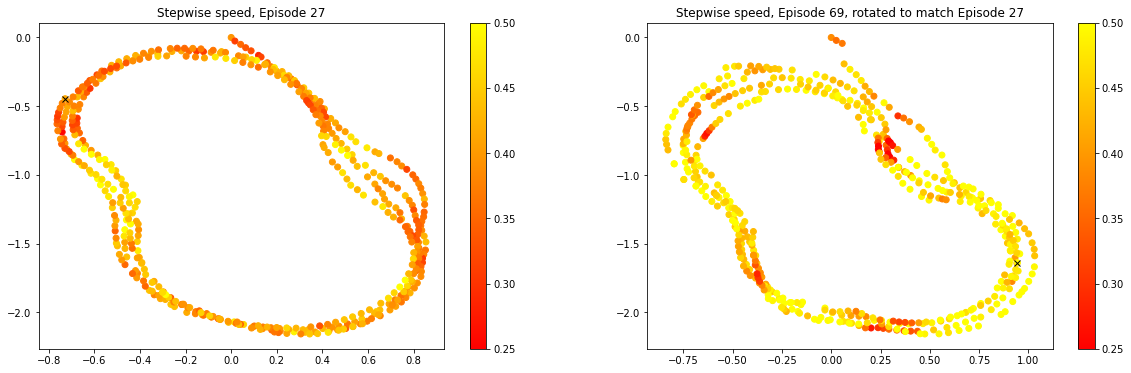

In [313]:
plt.figure(1, (20, 6))
episode = data[data.Episode == 26]
x = episode["PosX"].values[10:]
z = episode["PosZ"].values[10:]

plt.subplot(1, 2, 1)

plt.scatter(x - x[0], z - z[0], c=episode.Speed[10:], cmap = plt.cm.autumn)
plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
plt.title("Stepwise speed, Episode {}".format(27))
plt.colorbar()
plt.clim(0.25, 0.5)

plt.subplot(1, 2, 2)
episode = data[data.Episode == 68]
x = episode["PosX"].values[10:] * -1
z = episode["PosZ"].values[10:] * -1

plt.scatter(x - x[0], z - z[0], c=episode.Speed[10:], cmap = plt.cm.autumn)
plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
plt.title("Stepwise speed, Episode {}, rotated to match Episode 27".format(69))
plt.colorbar()
plt.clim(0.25, 0.5)
#plt.title("Drift in position over time", size = 14)
#plt.xlim((-2, 1))
#plt.ylim((-2, 1.5))

### Here is each episode visulized if you want to see the process

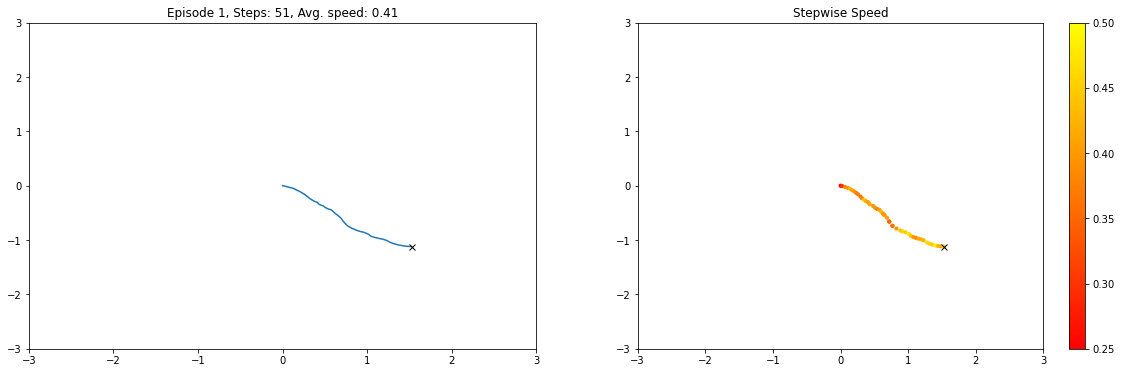

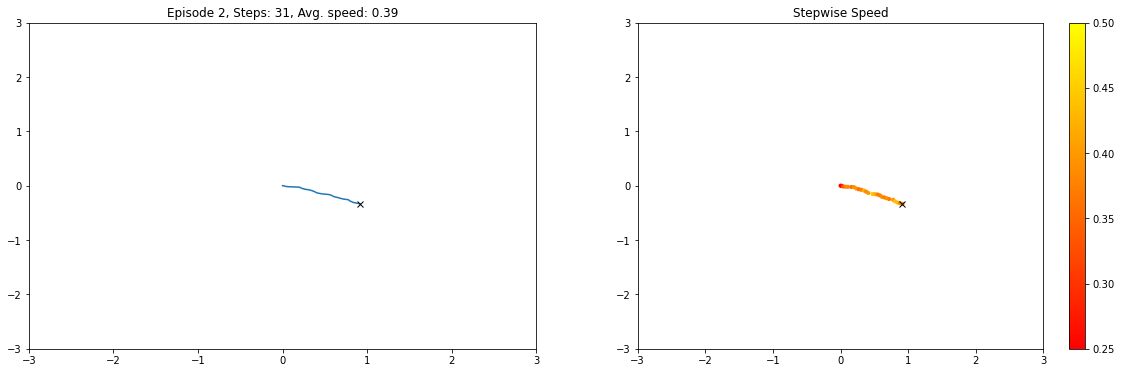

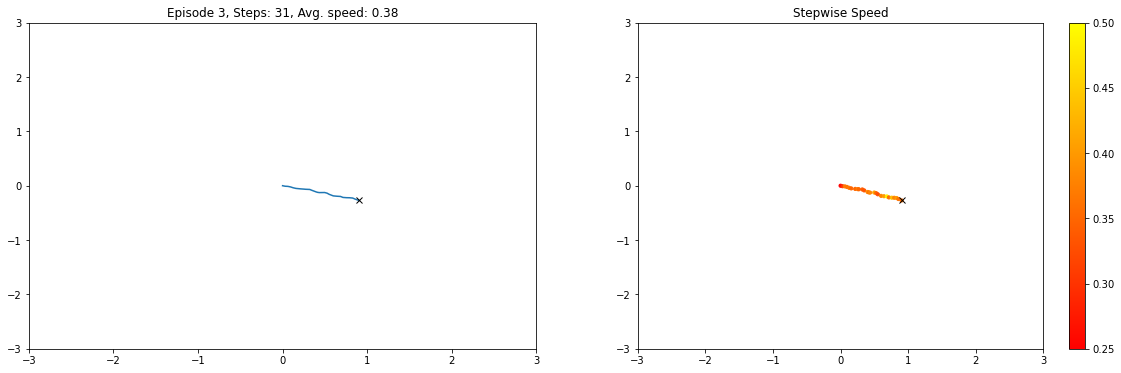

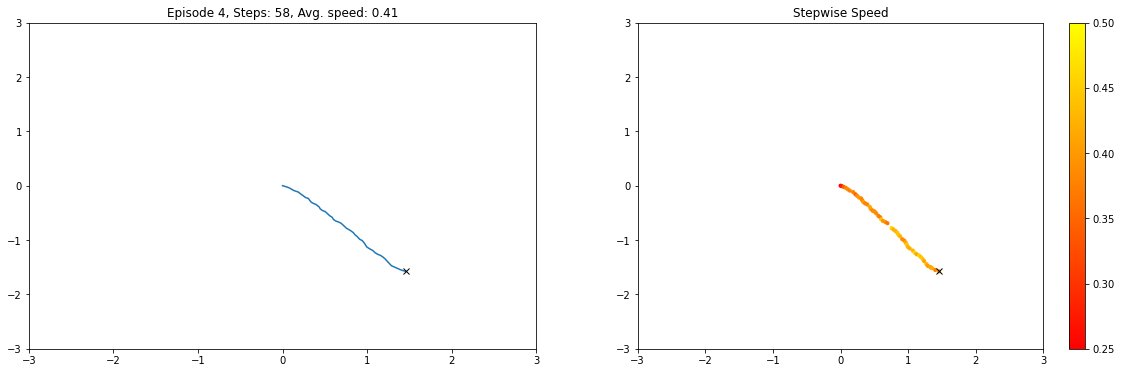

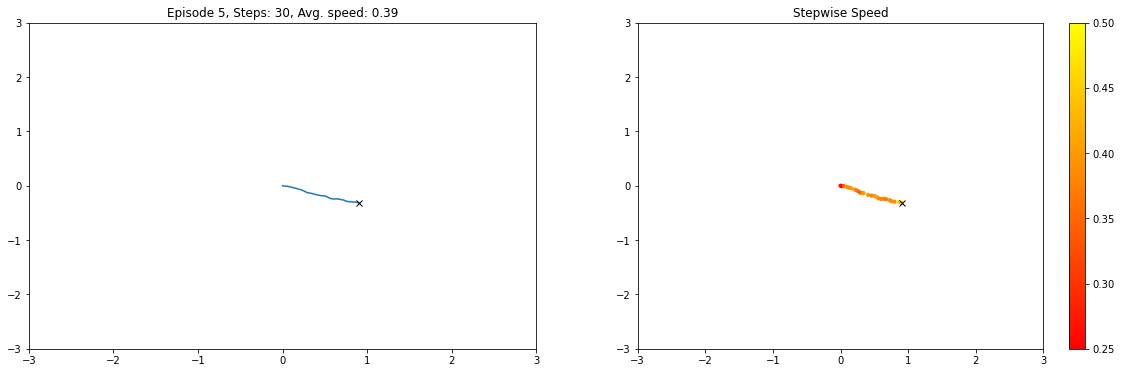

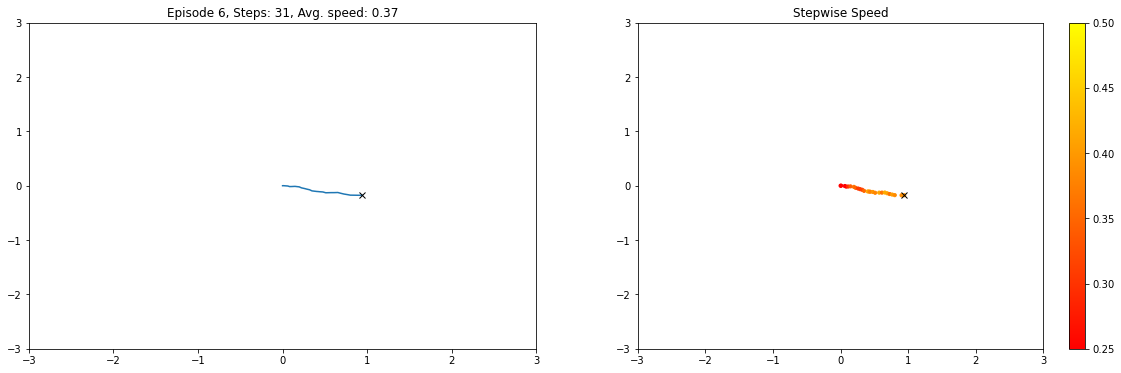

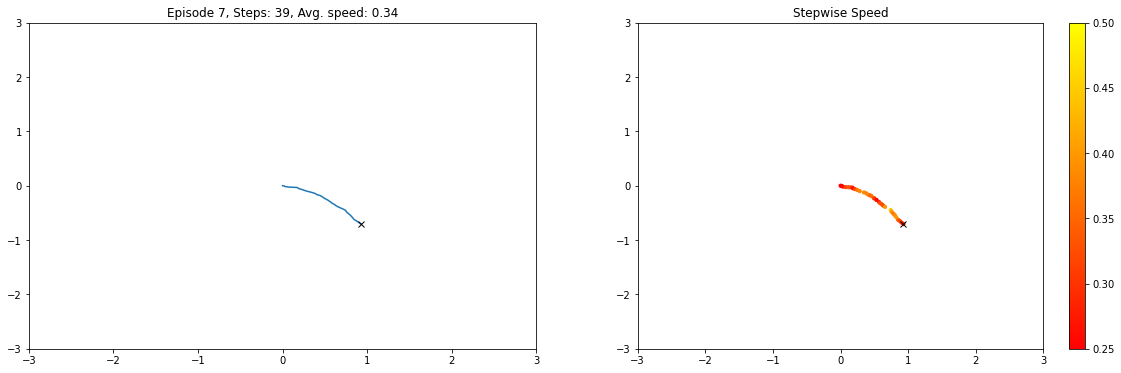

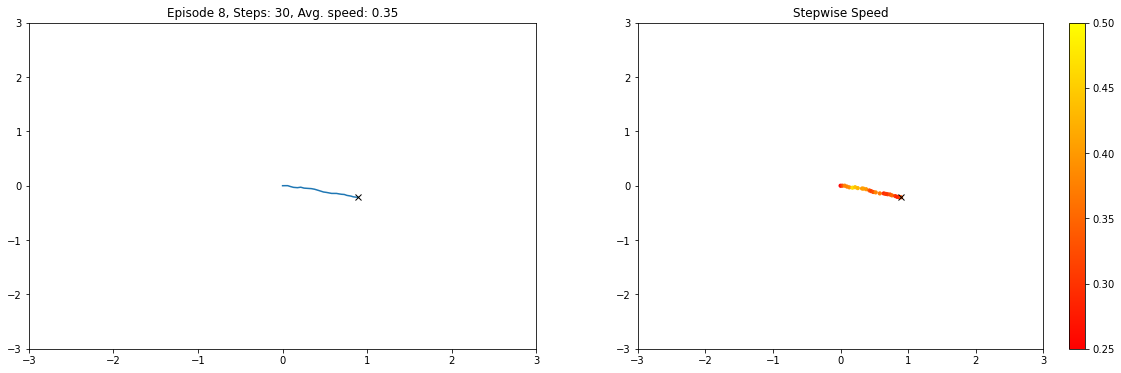

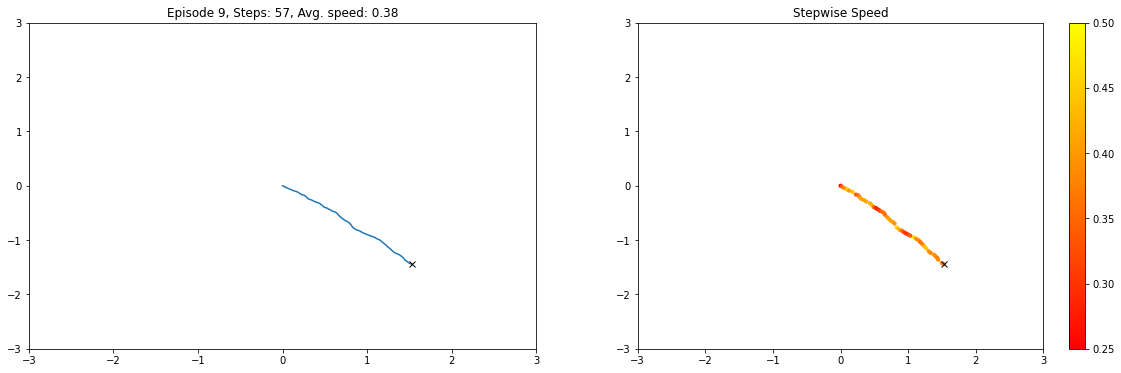

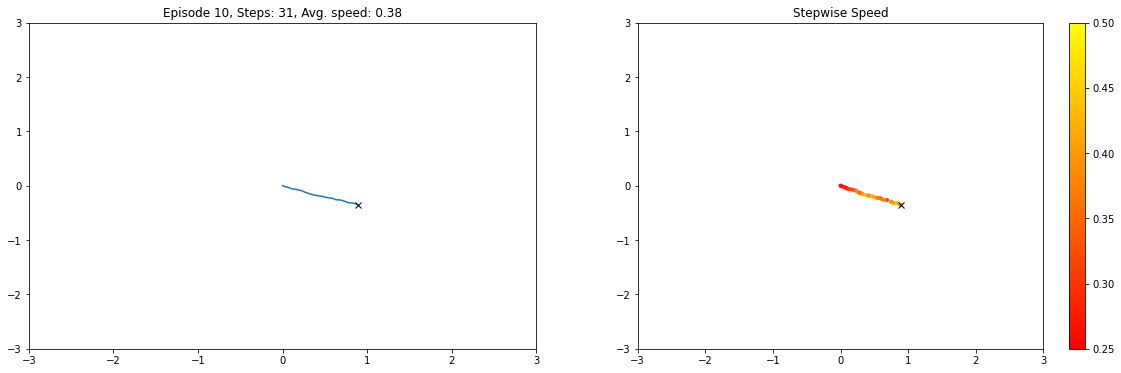

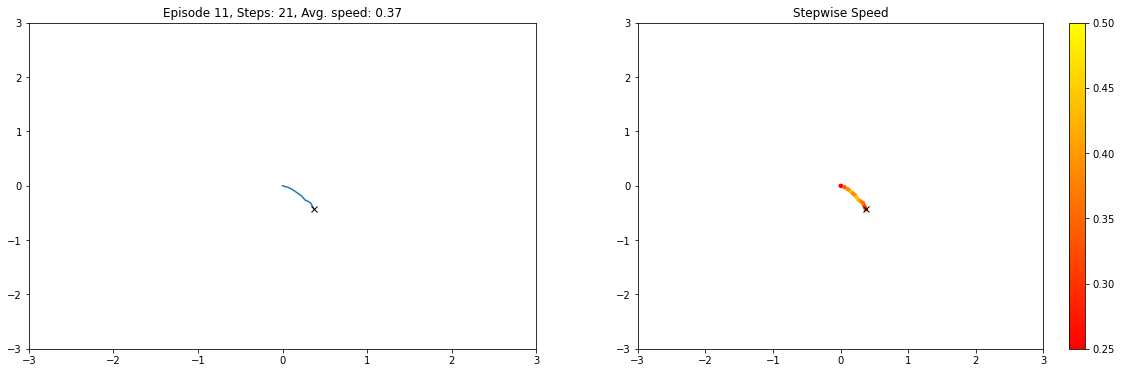

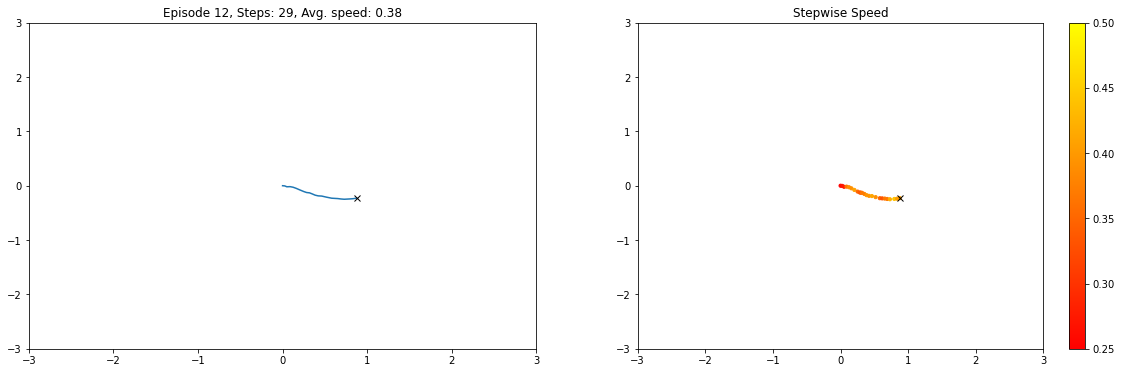

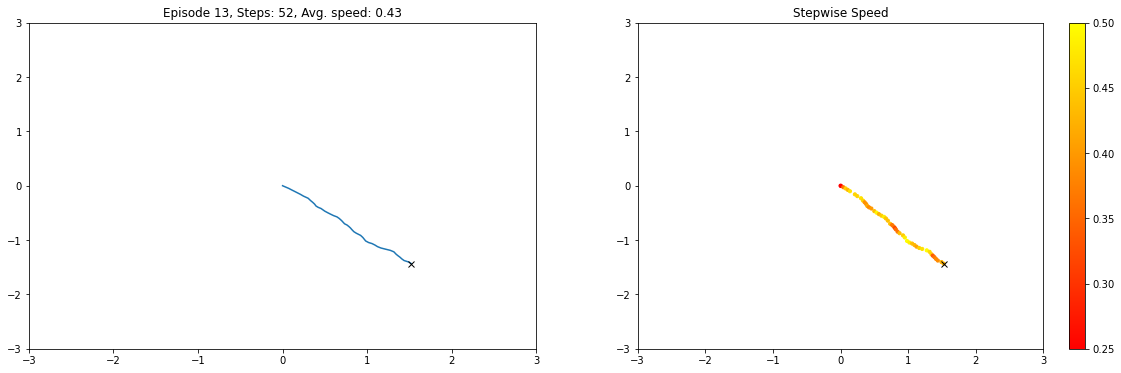

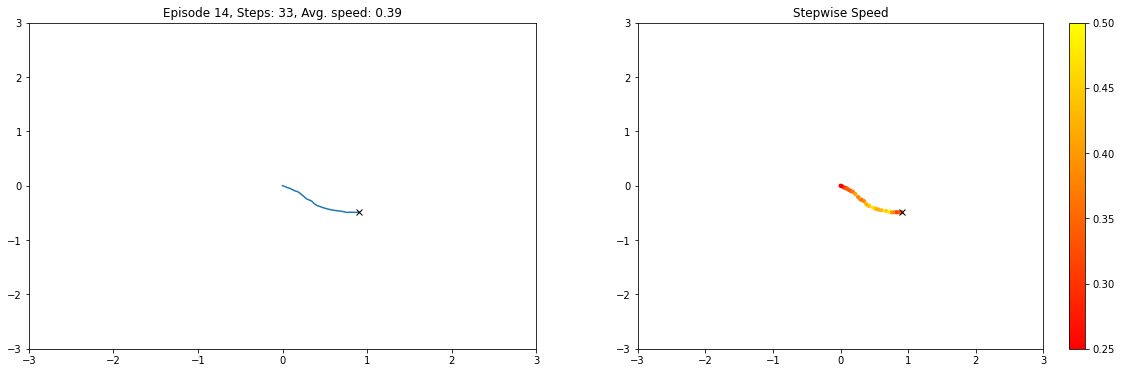

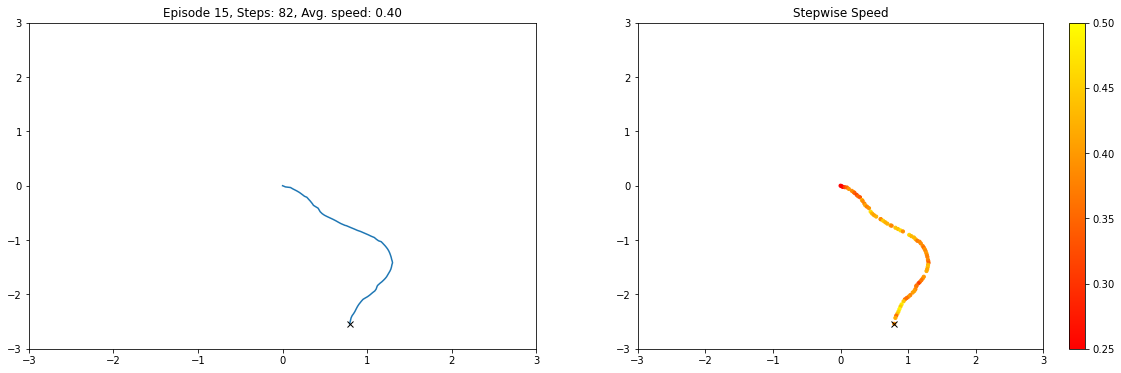

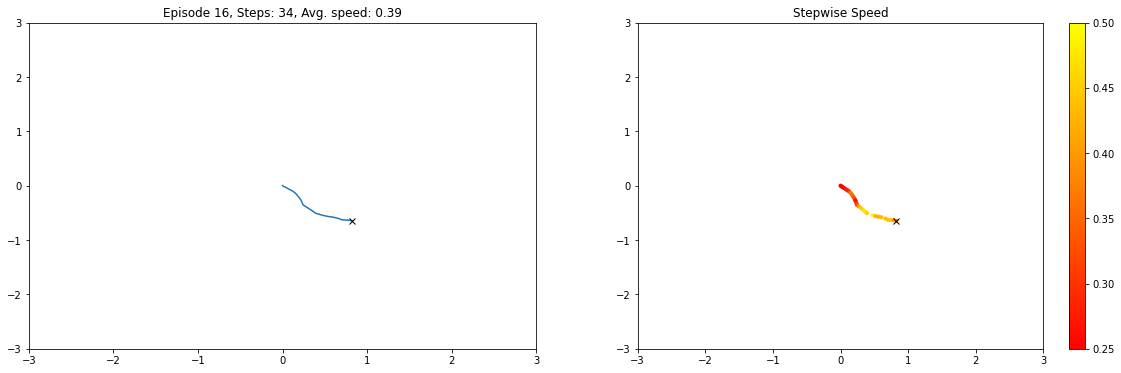

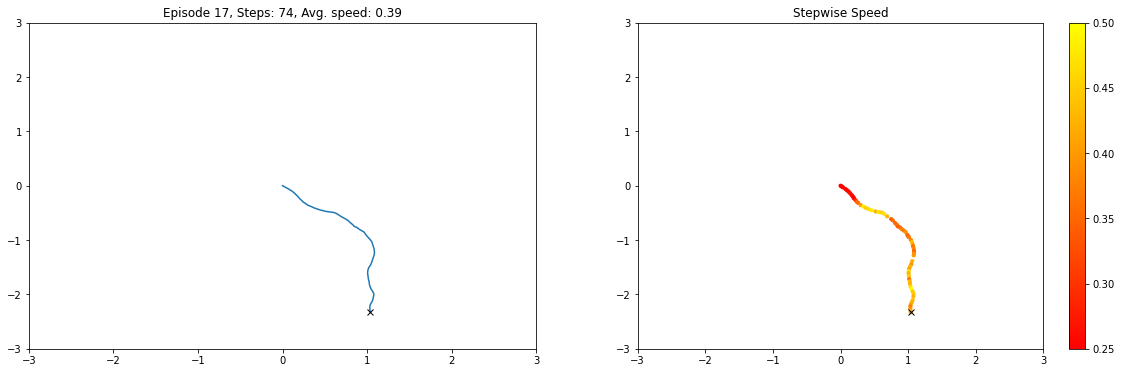

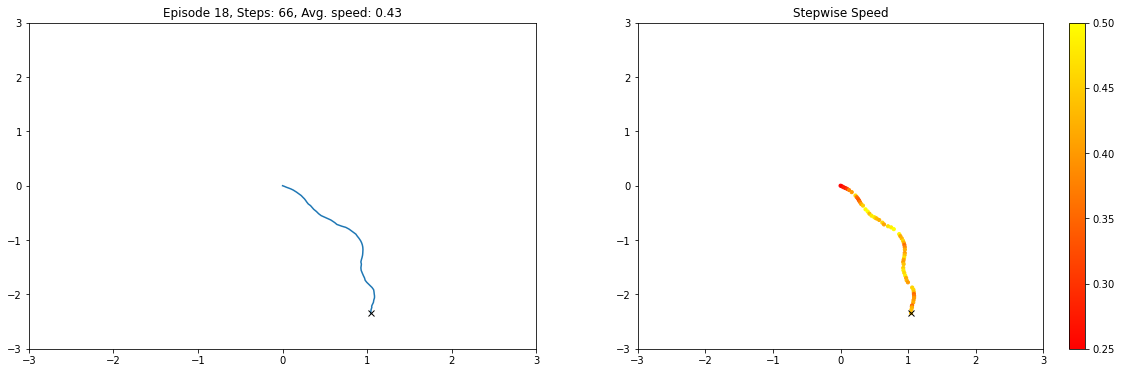

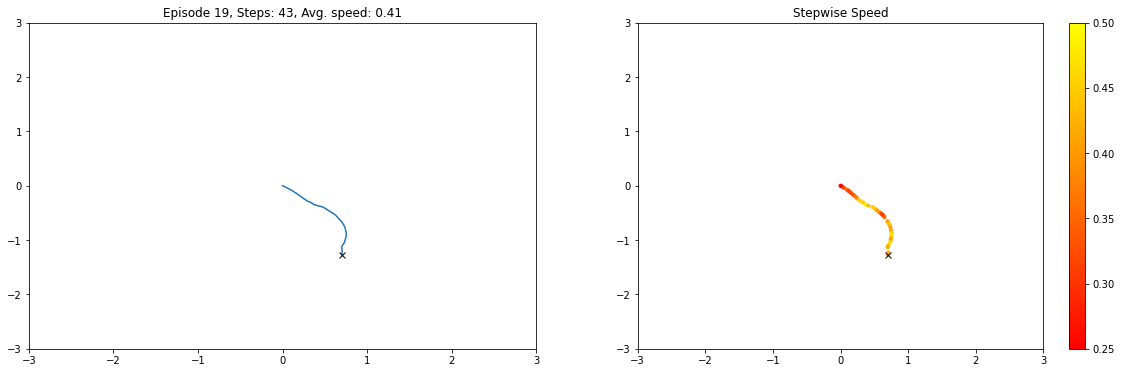

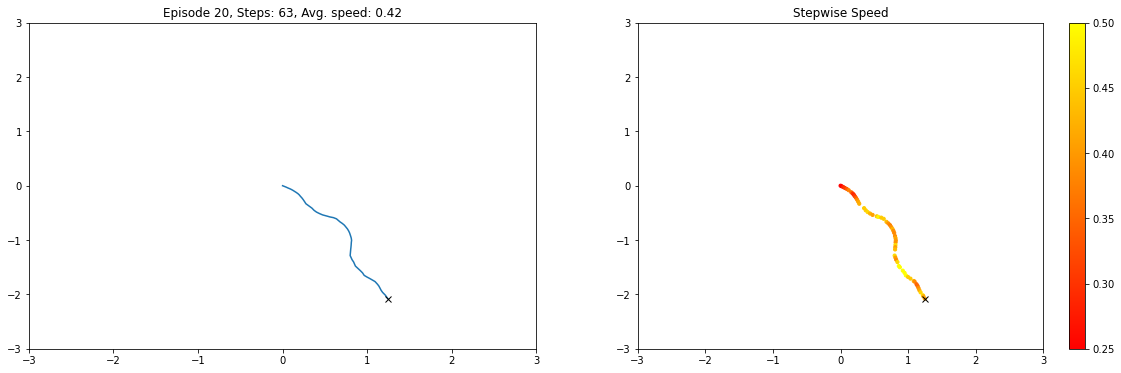

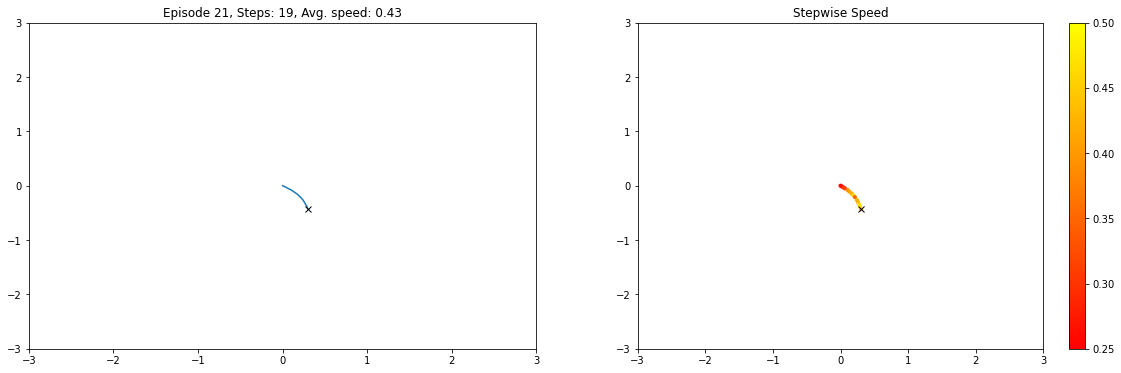

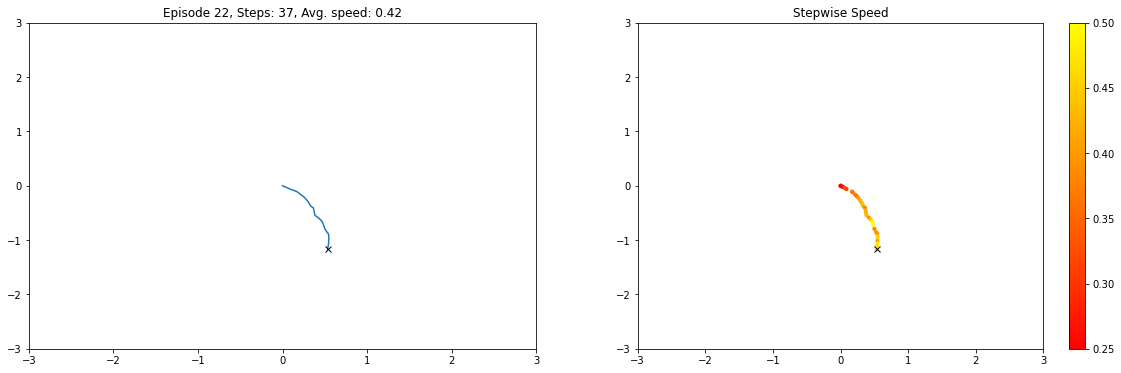

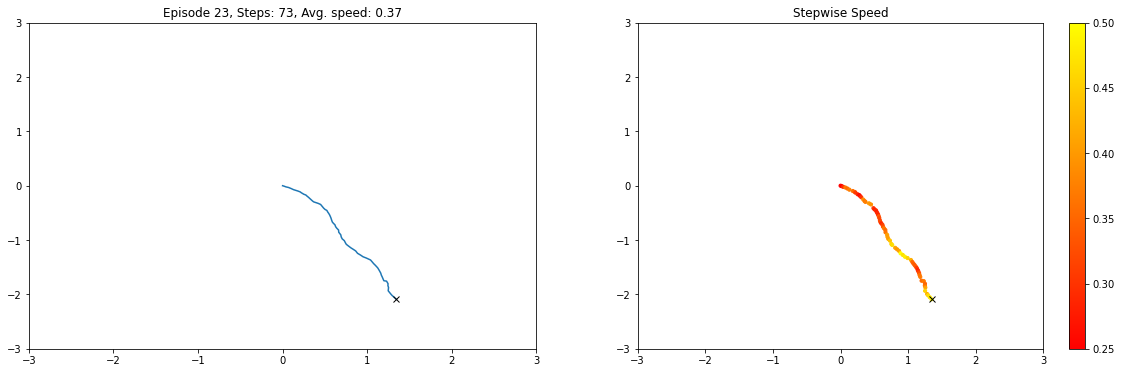

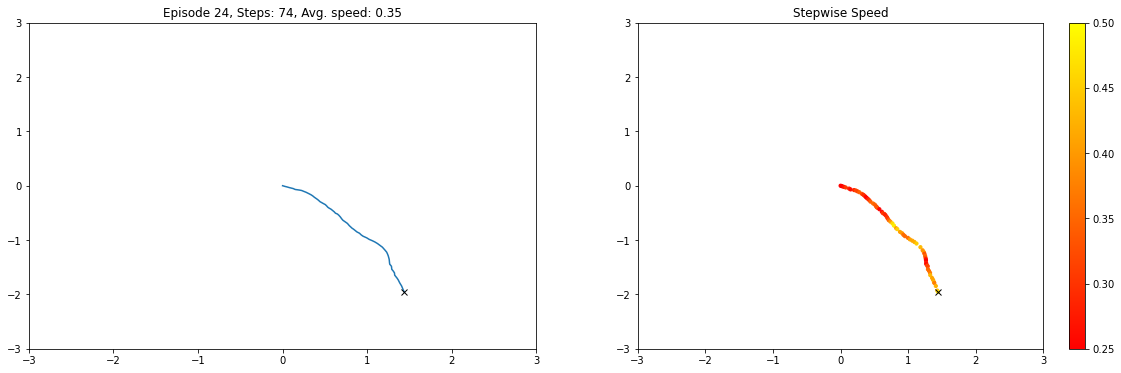

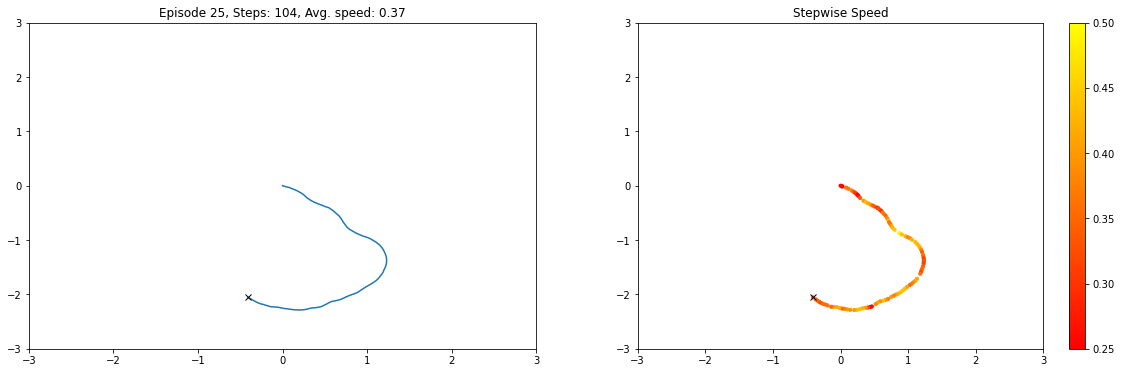

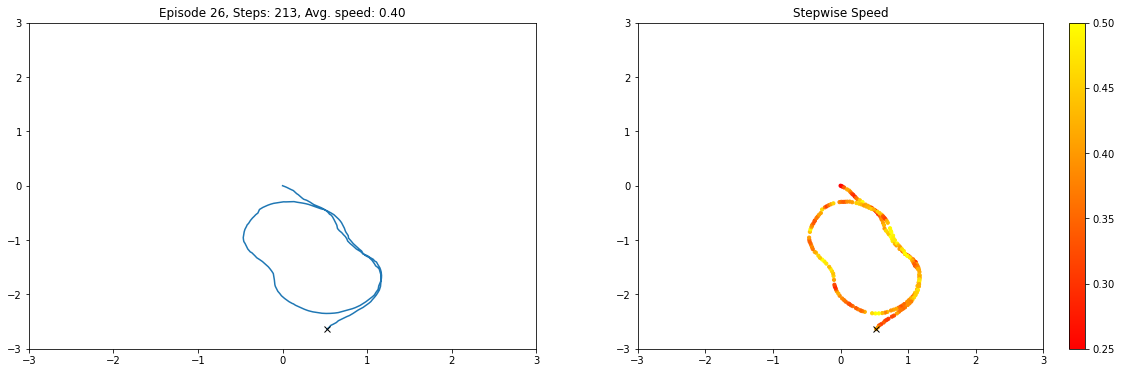

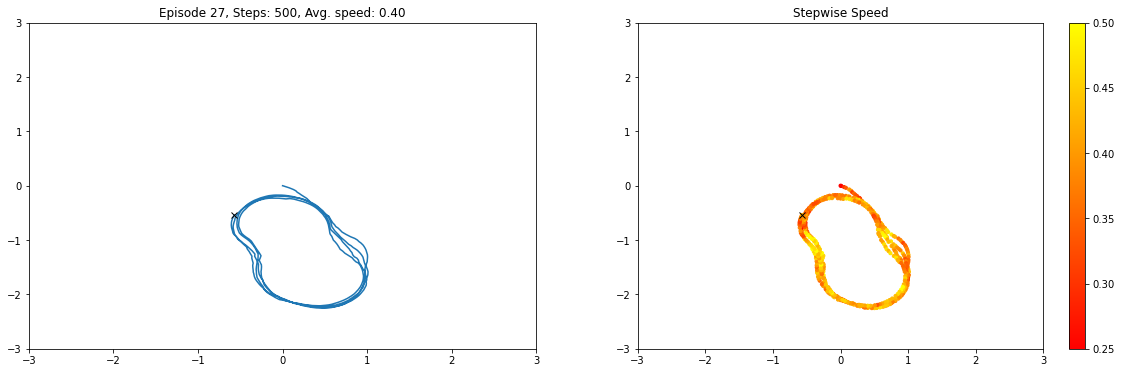

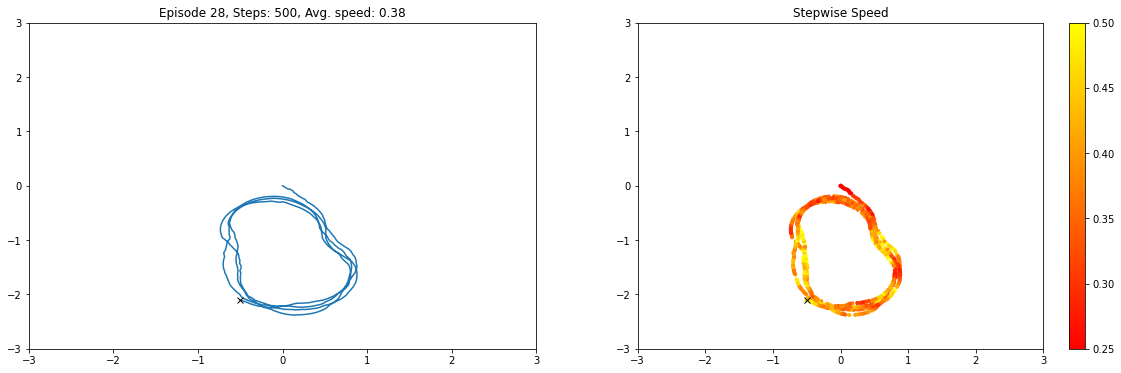

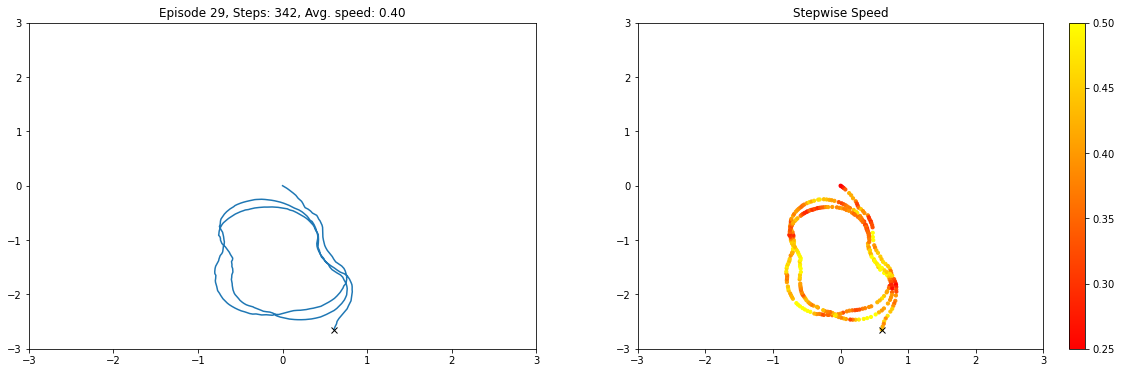

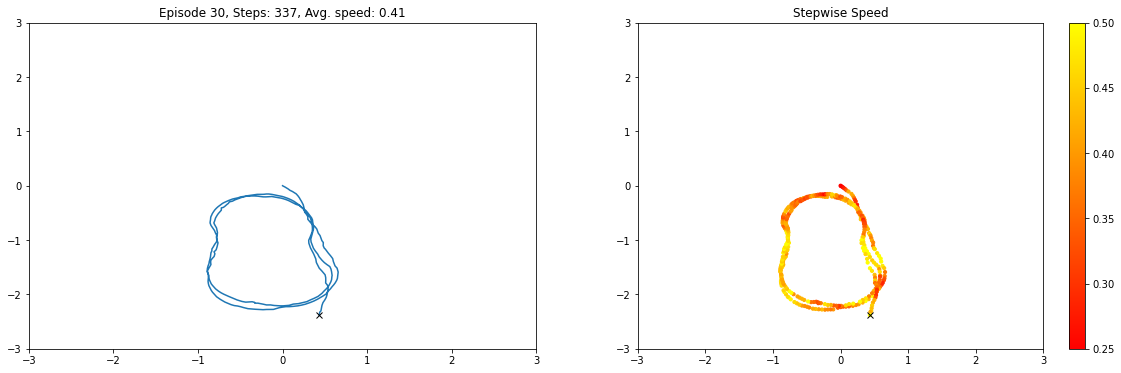

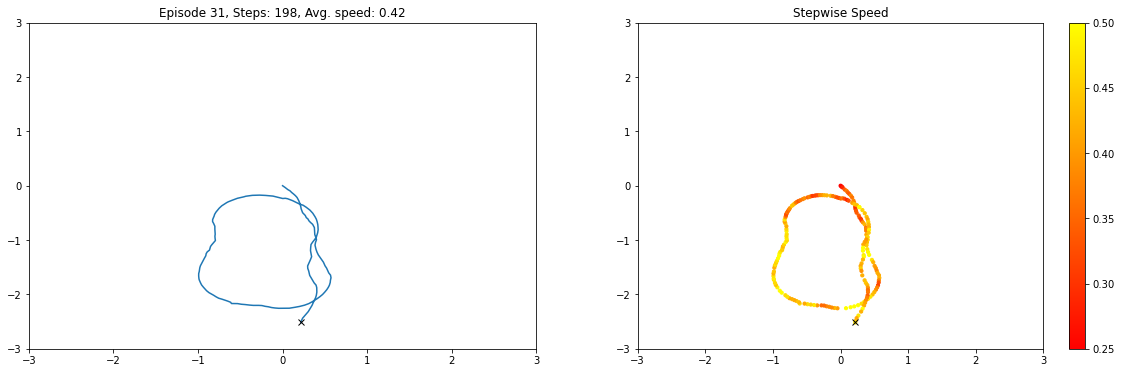

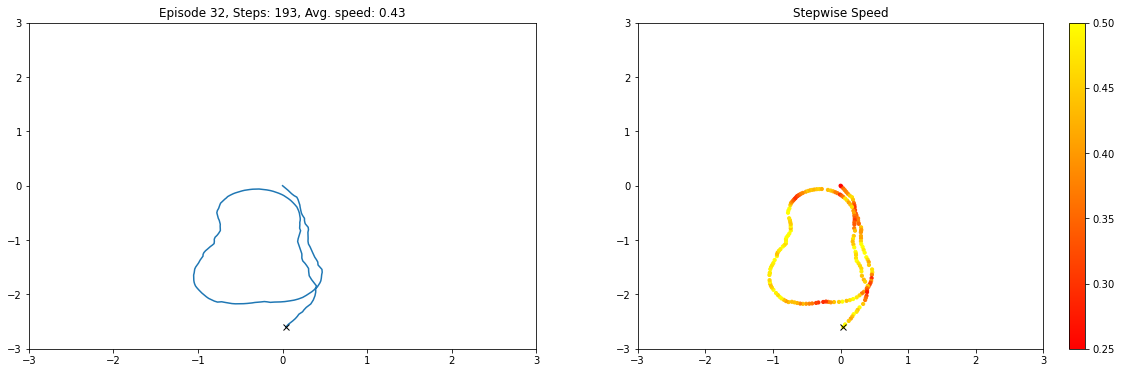

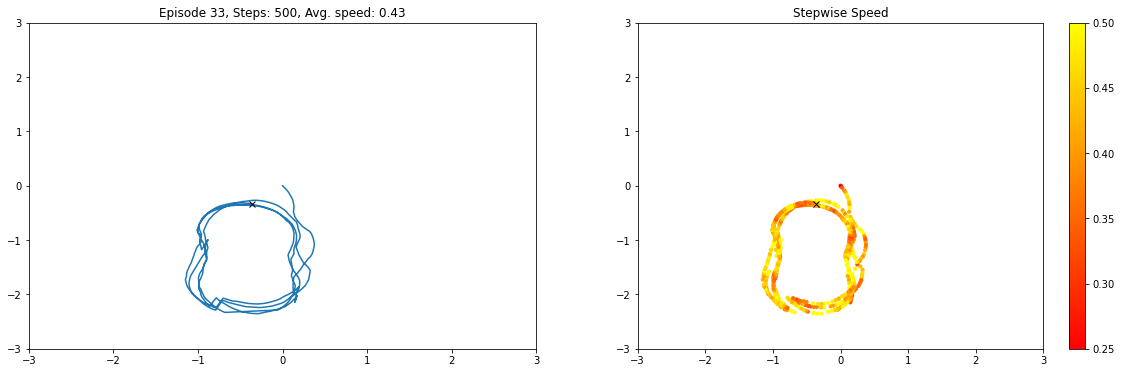

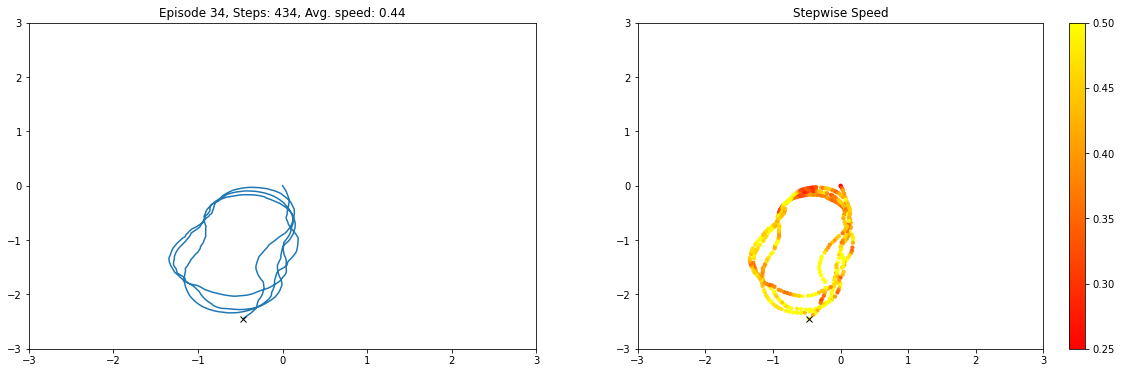

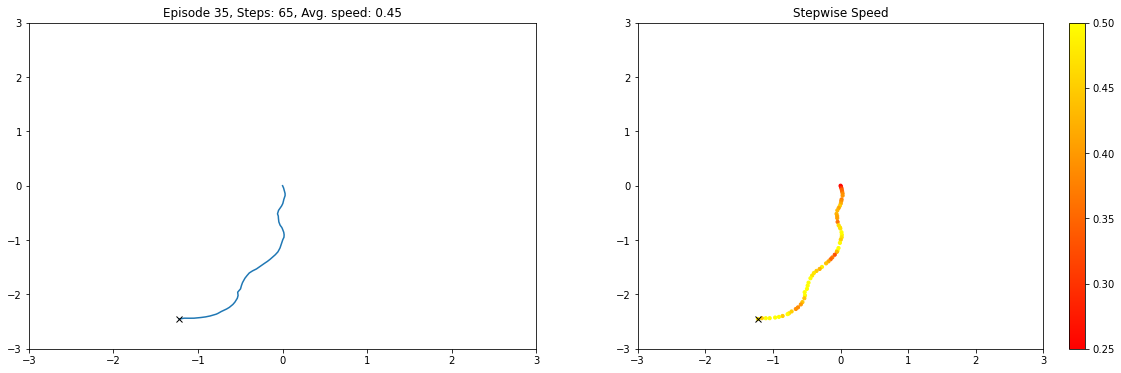

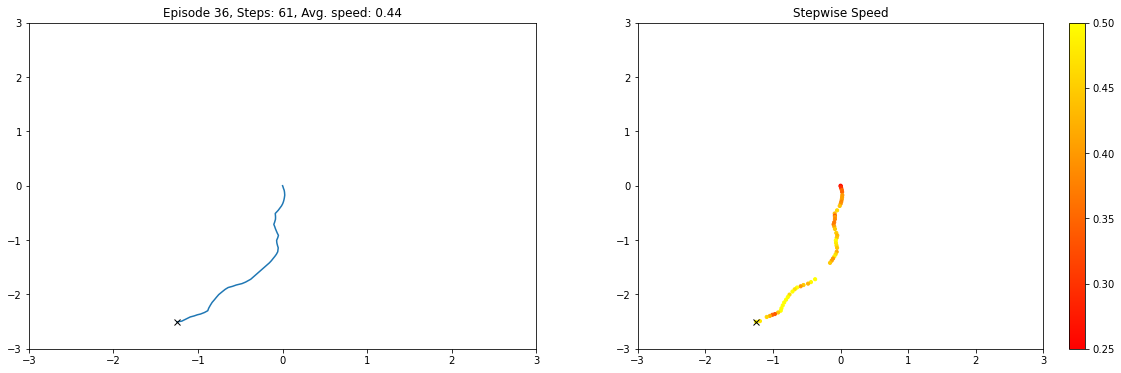

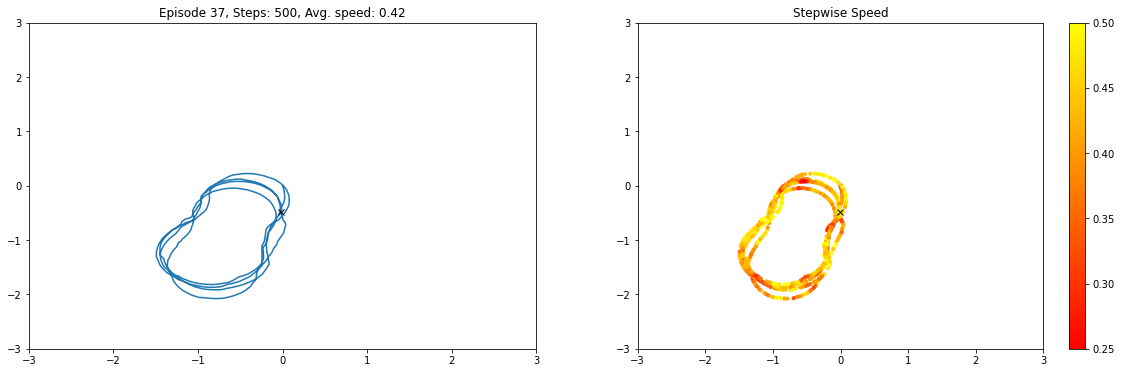

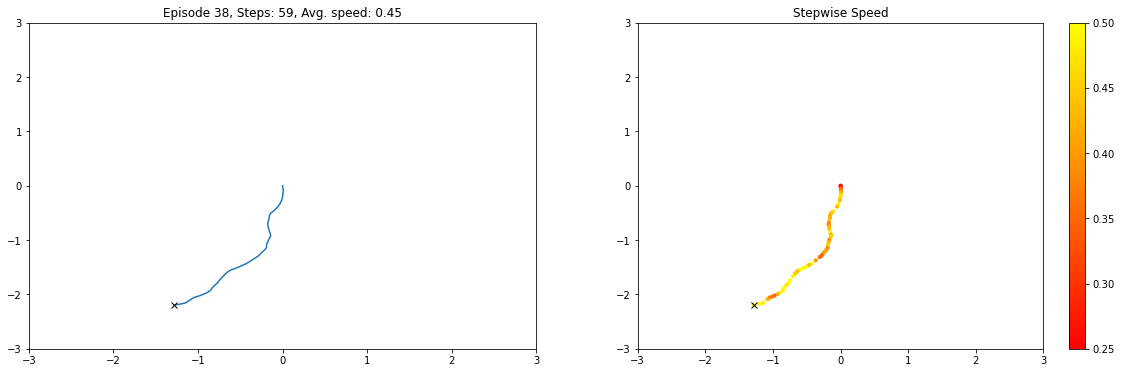

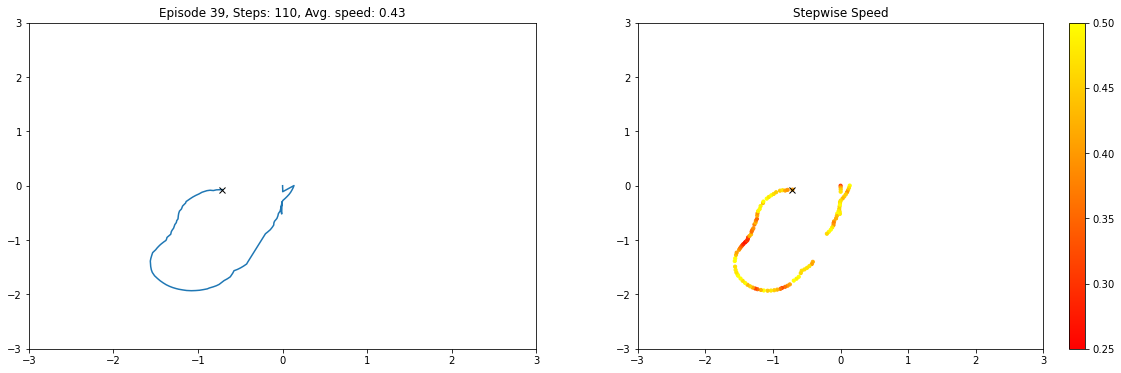

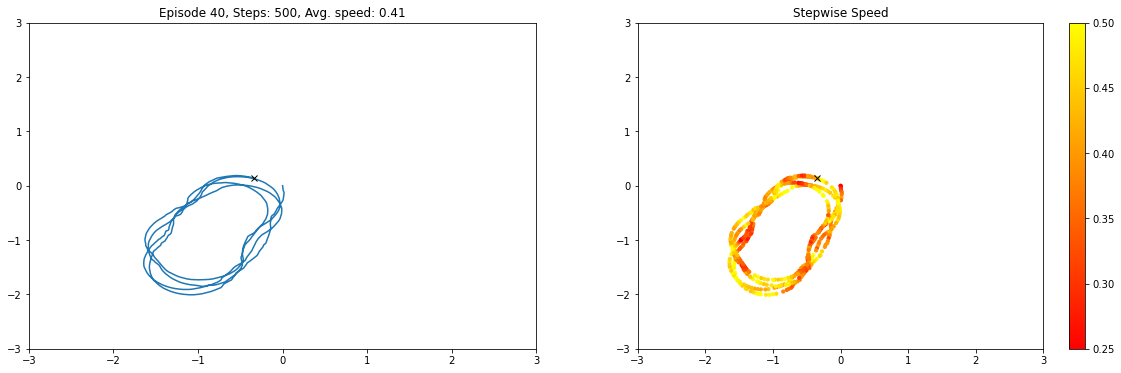

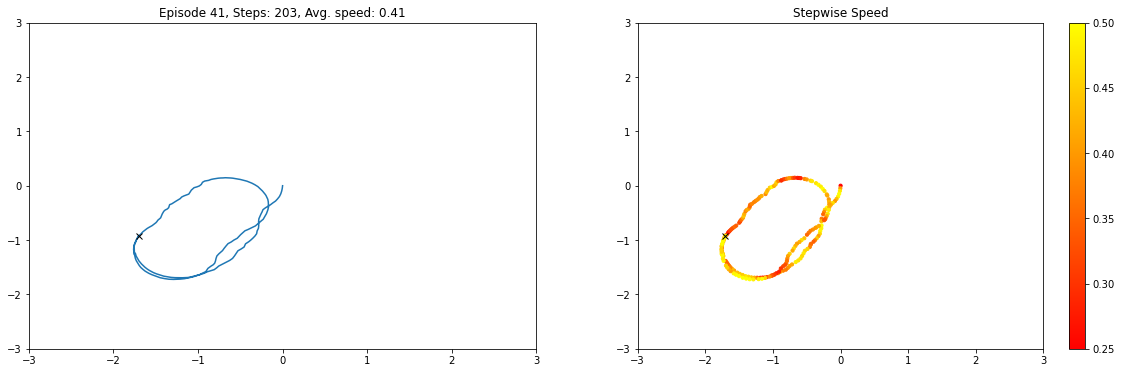

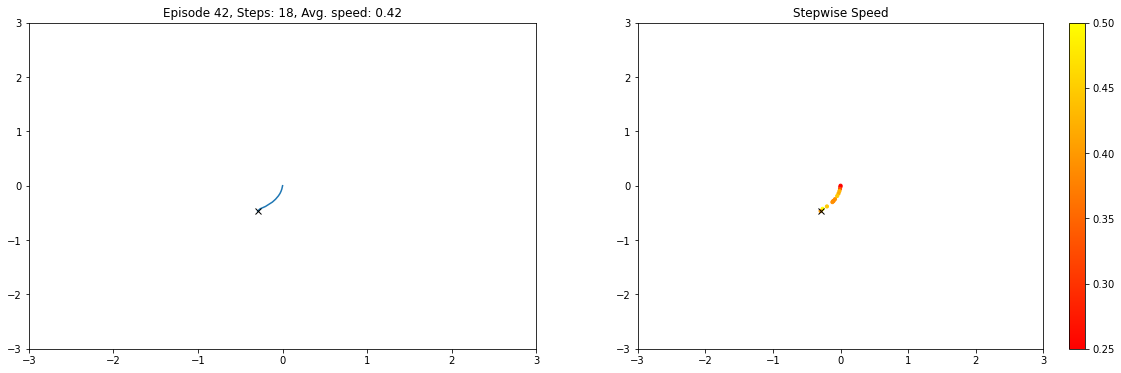

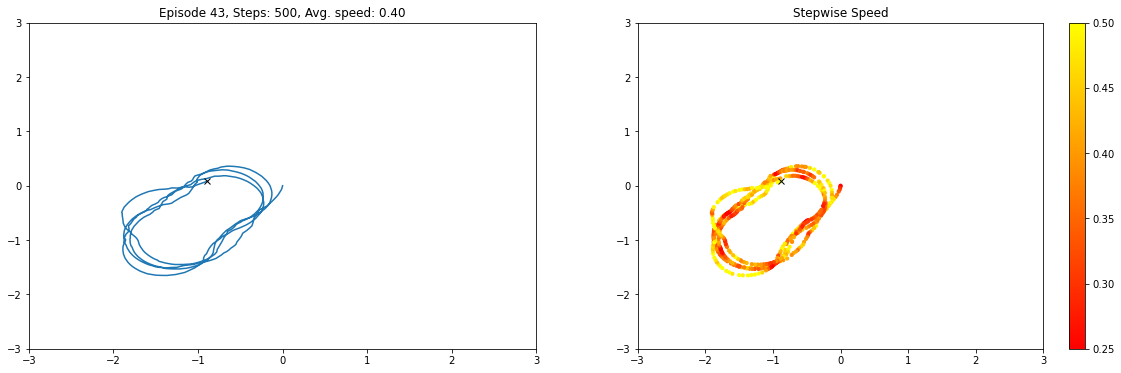

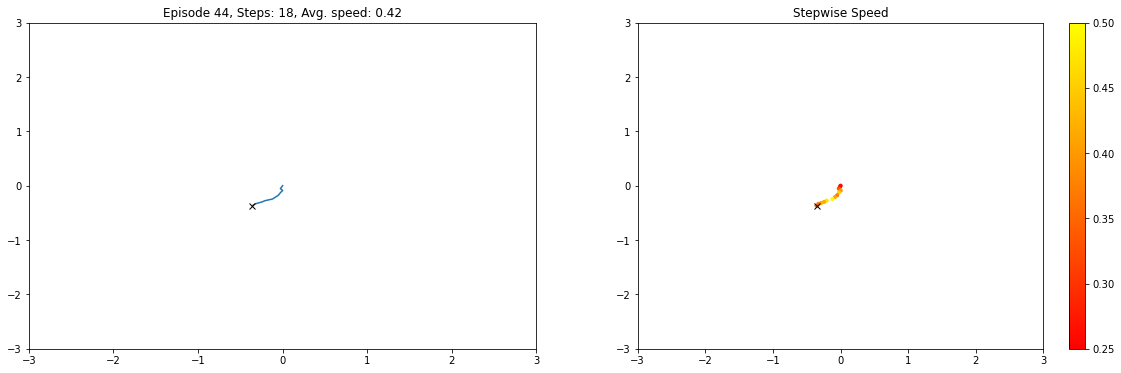

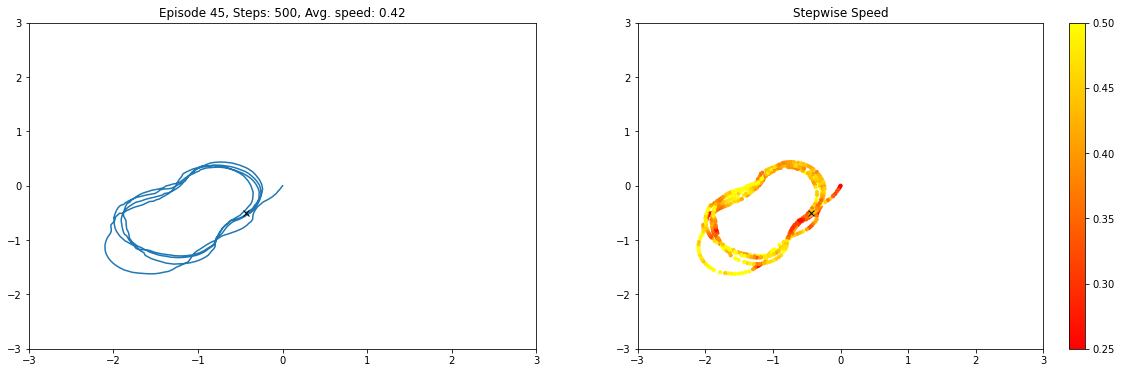

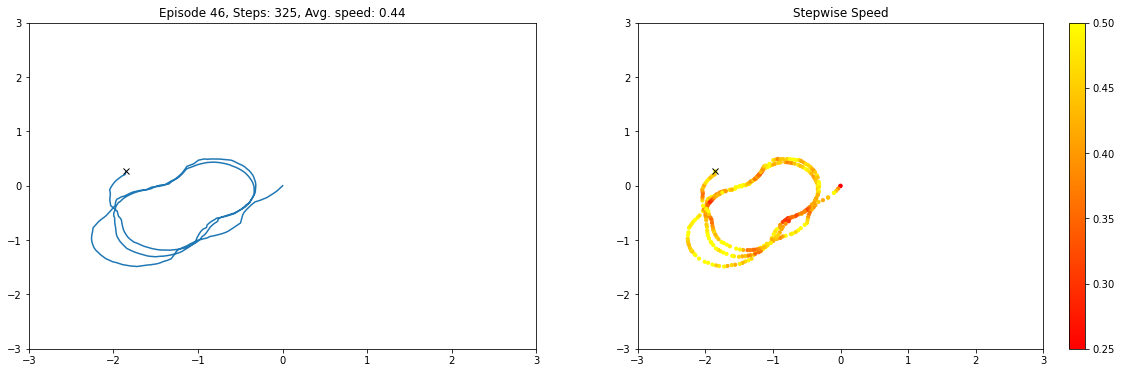

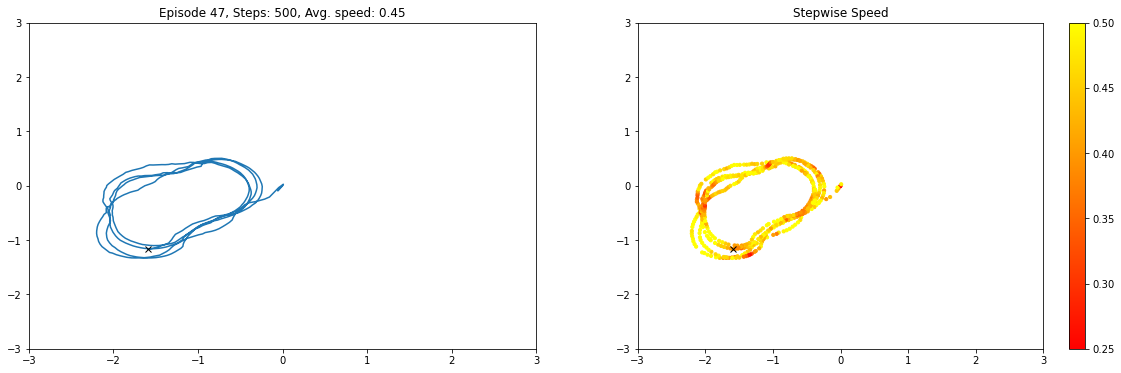

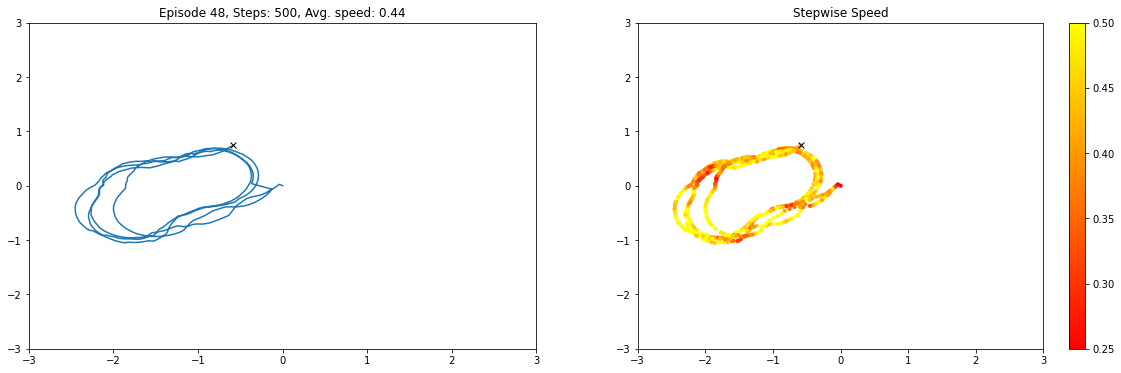

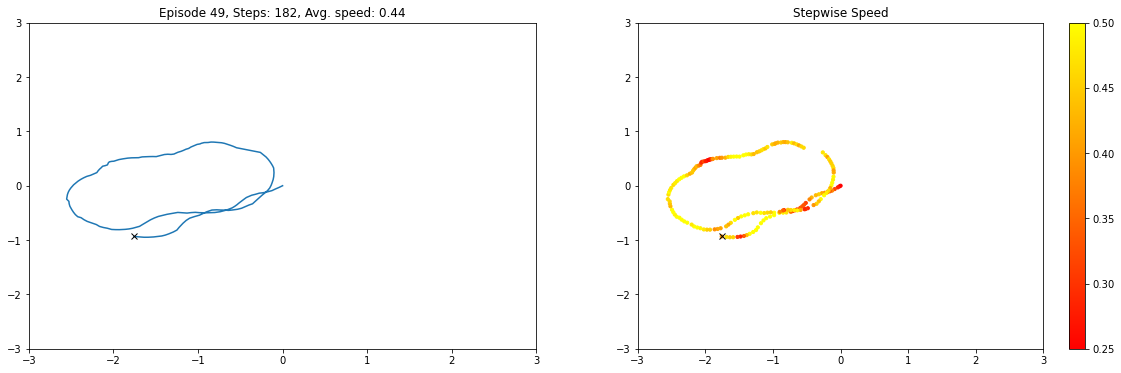

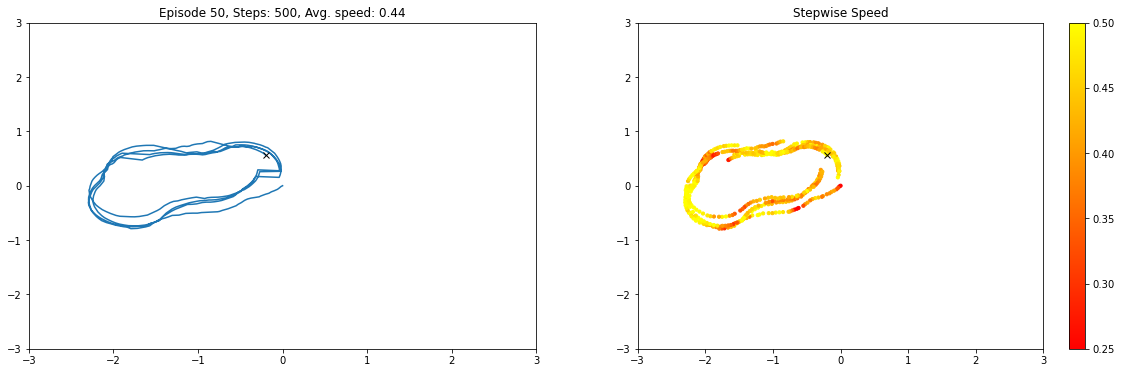

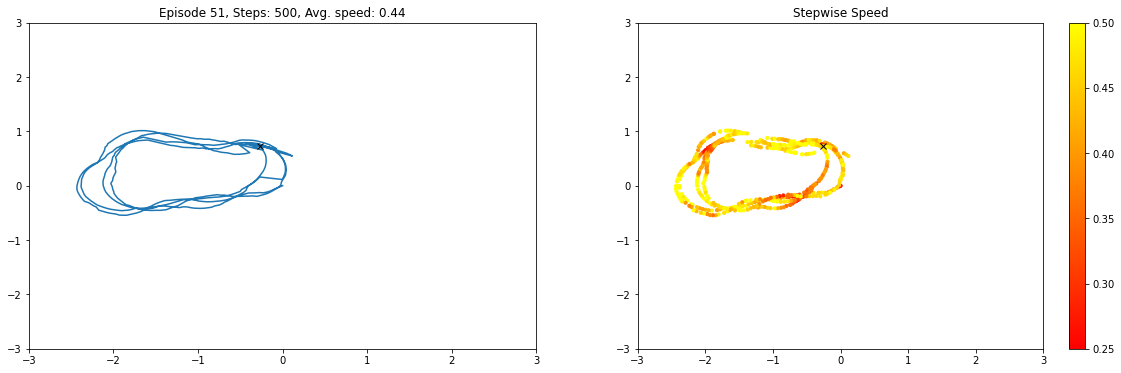

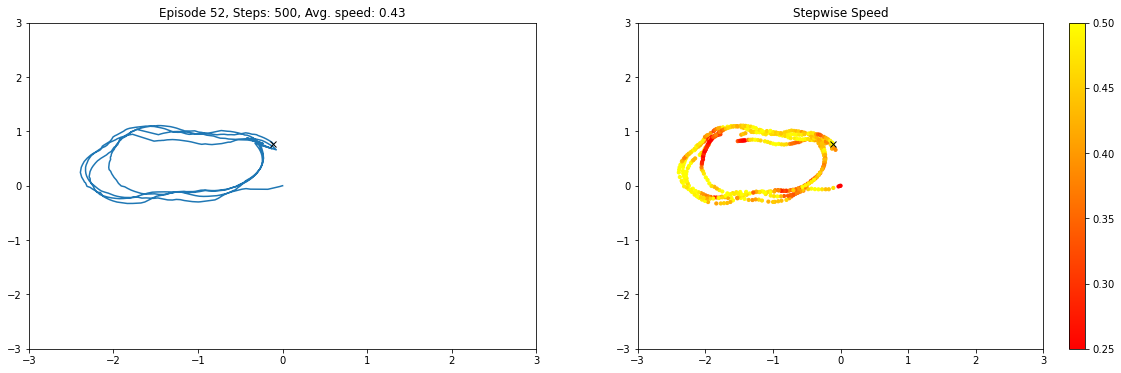

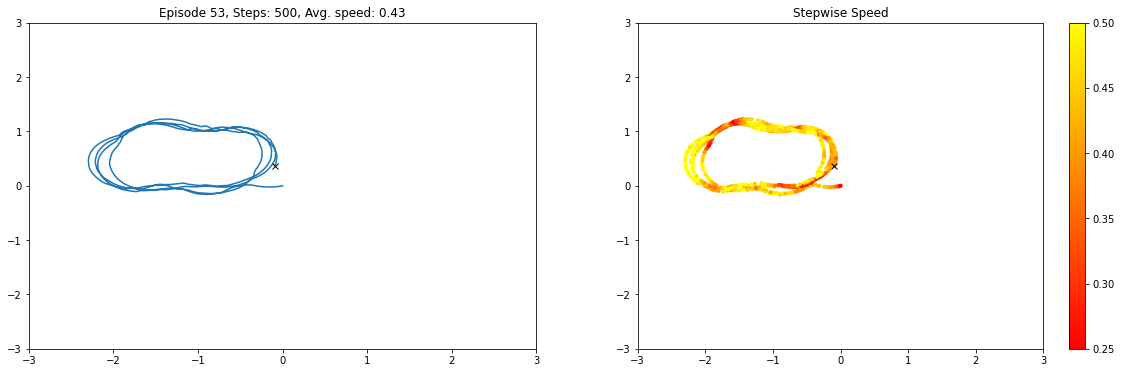

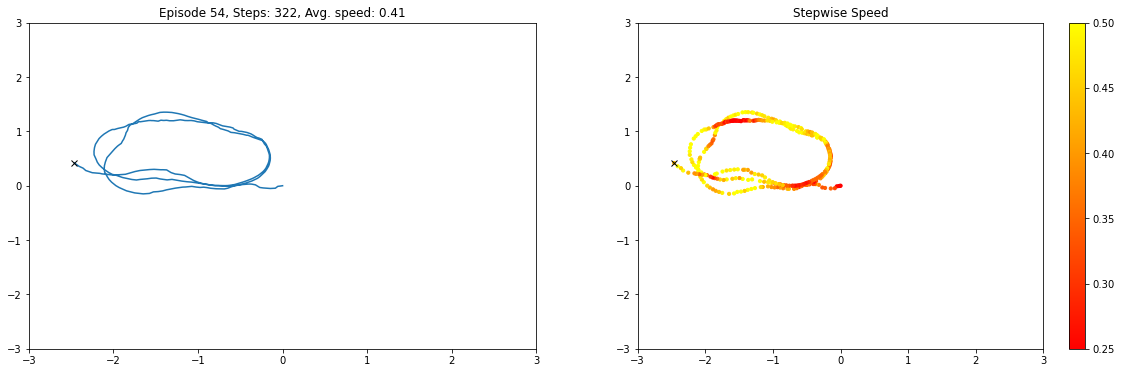

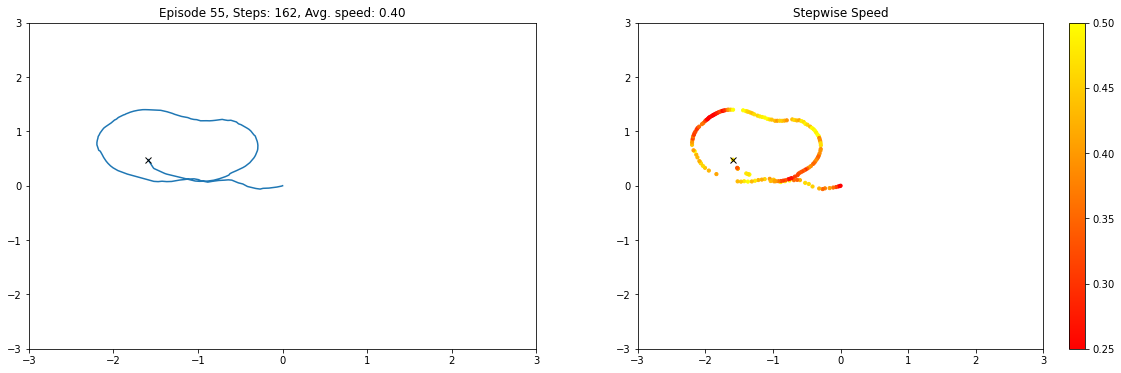

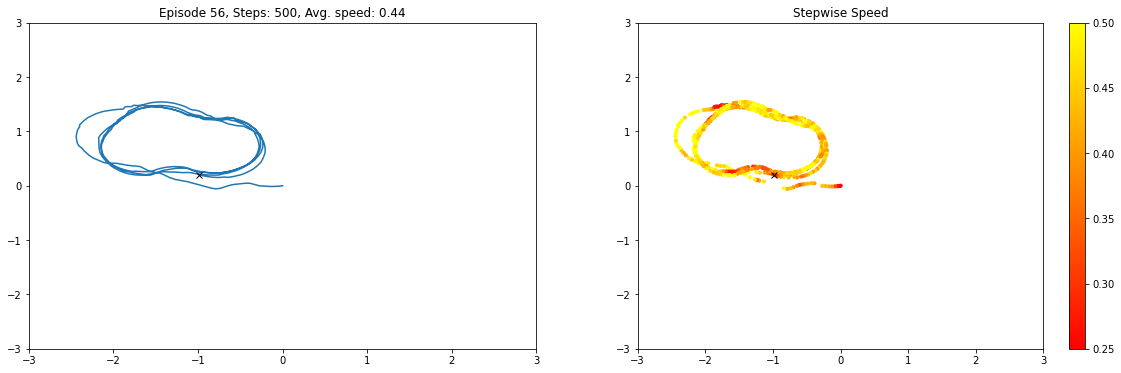

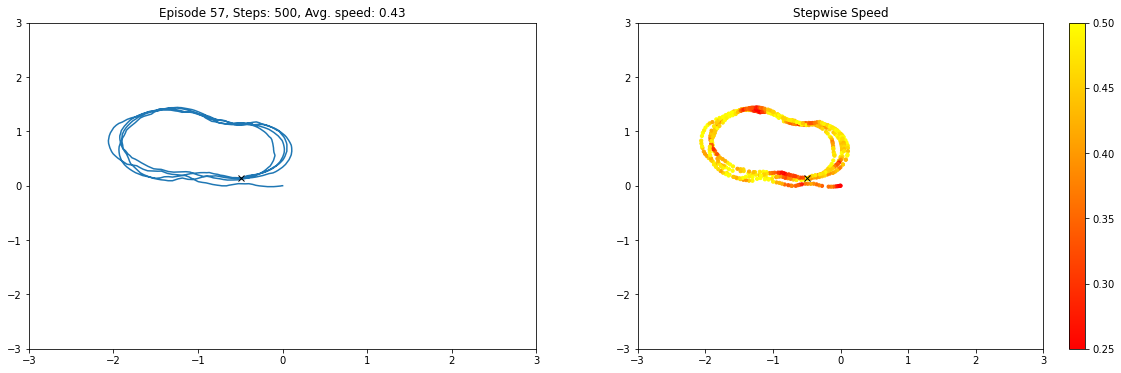

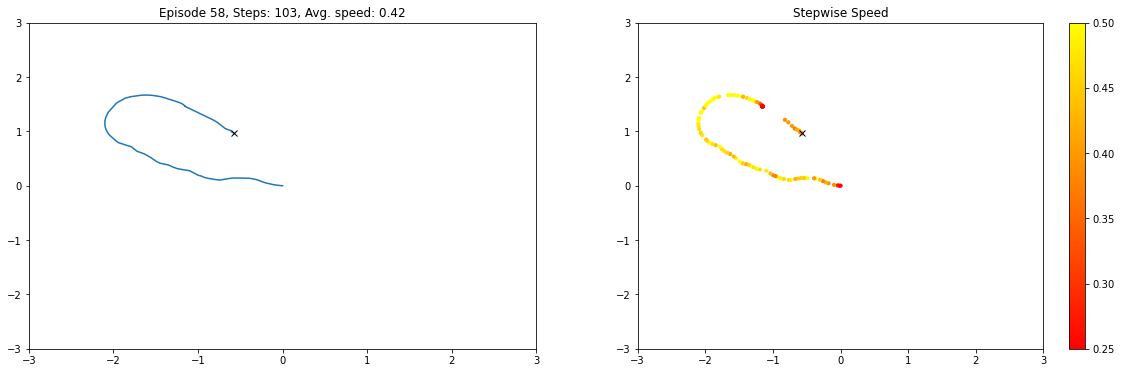

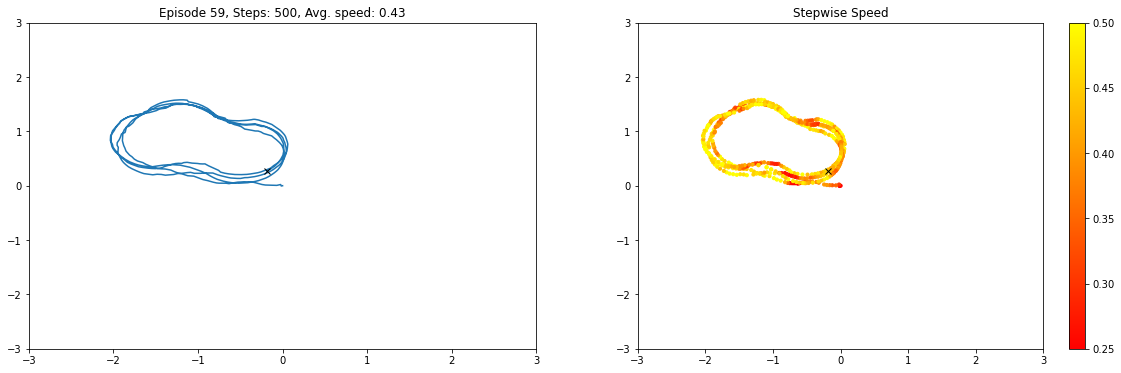

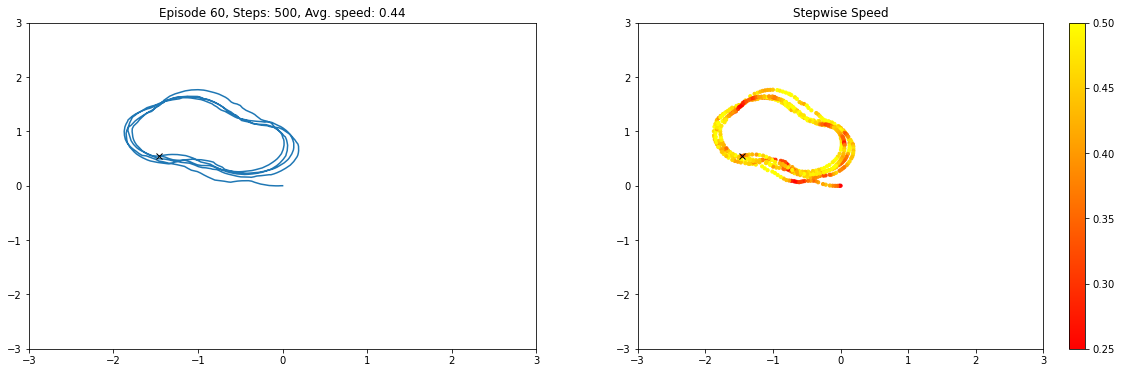

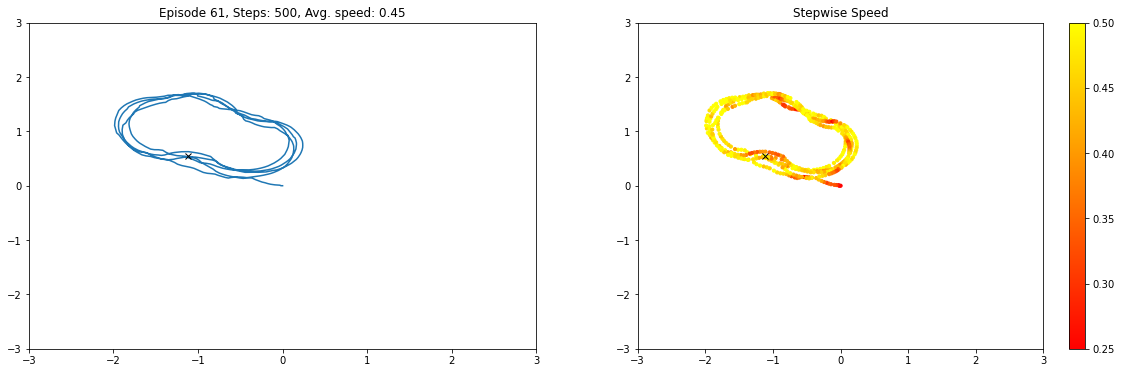

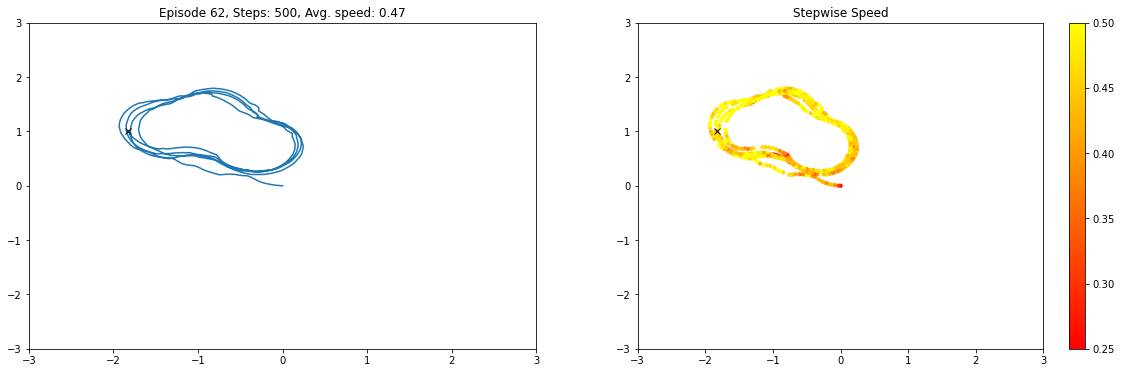

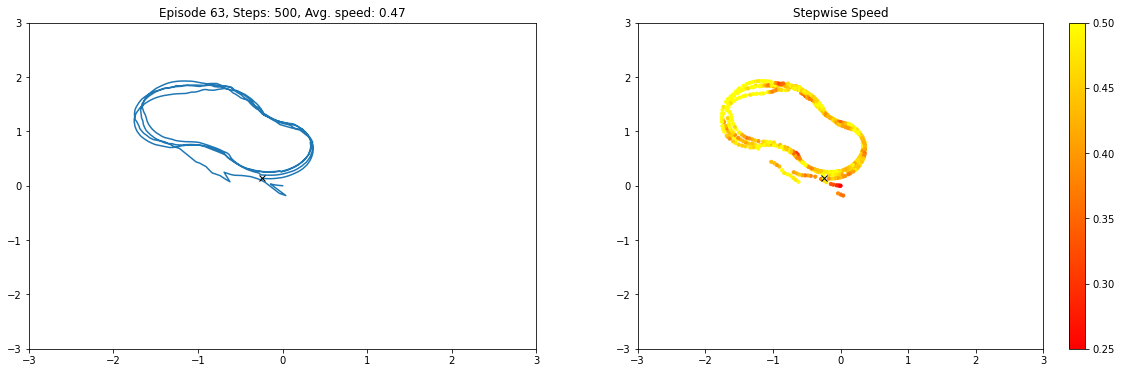

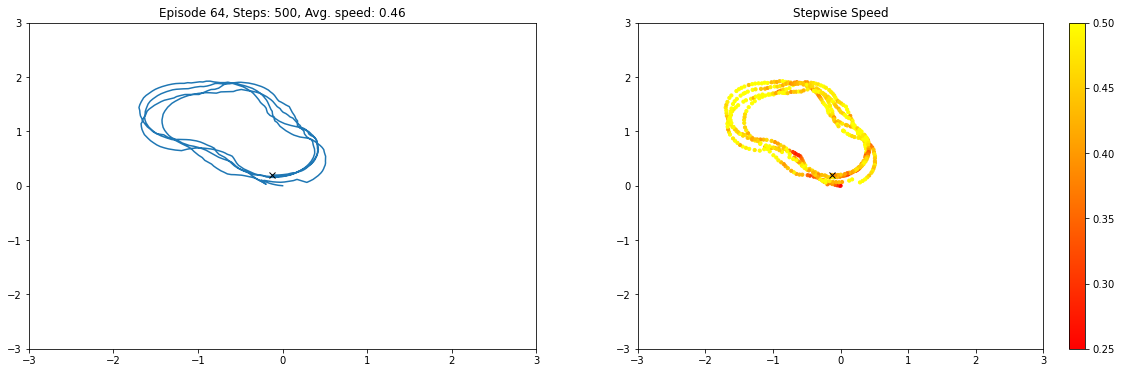

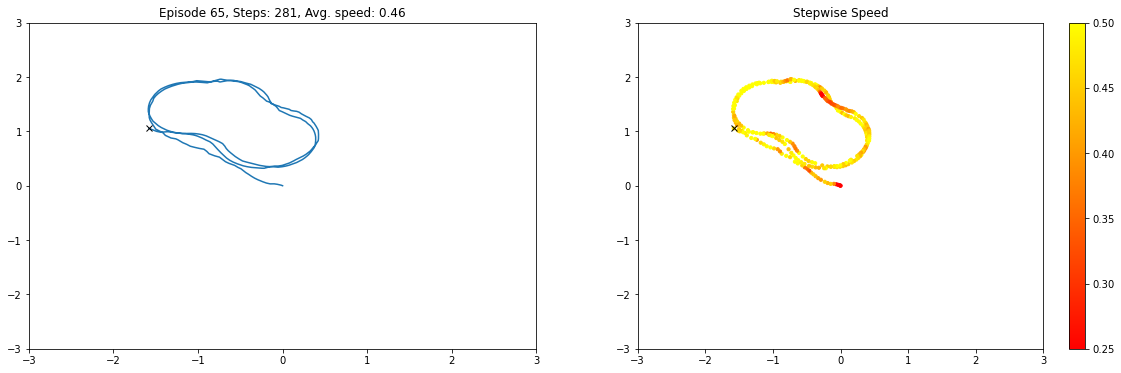

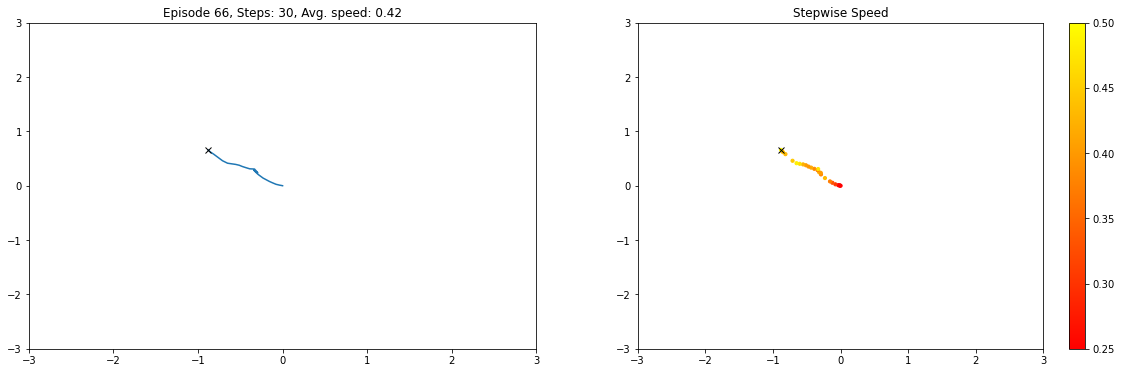

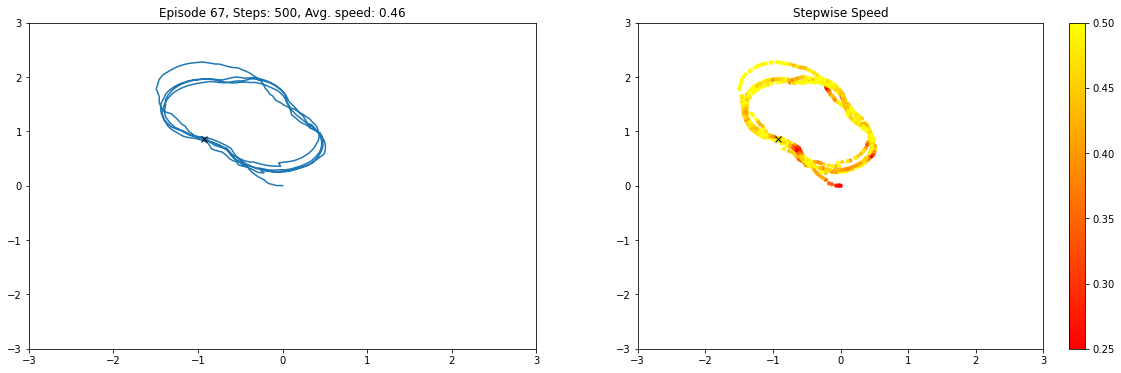

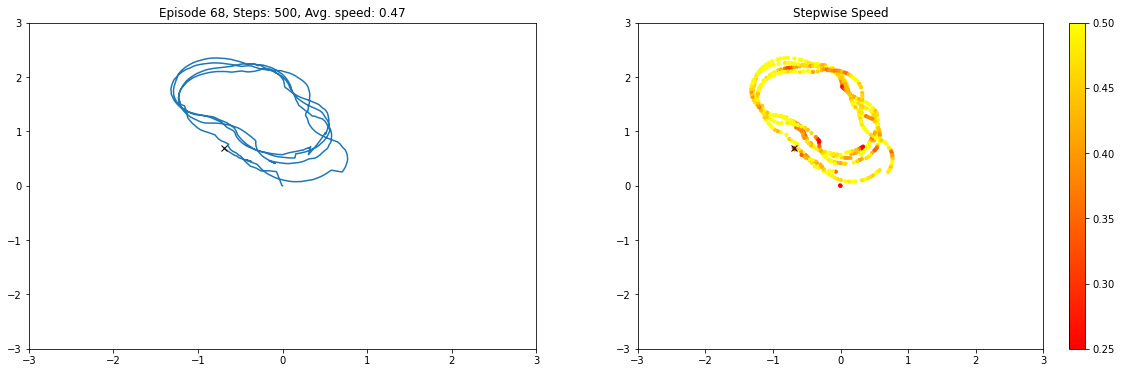

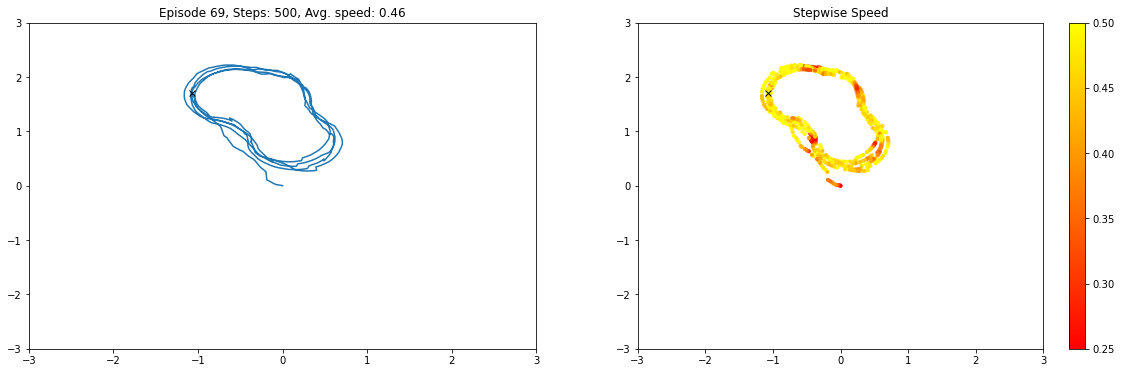

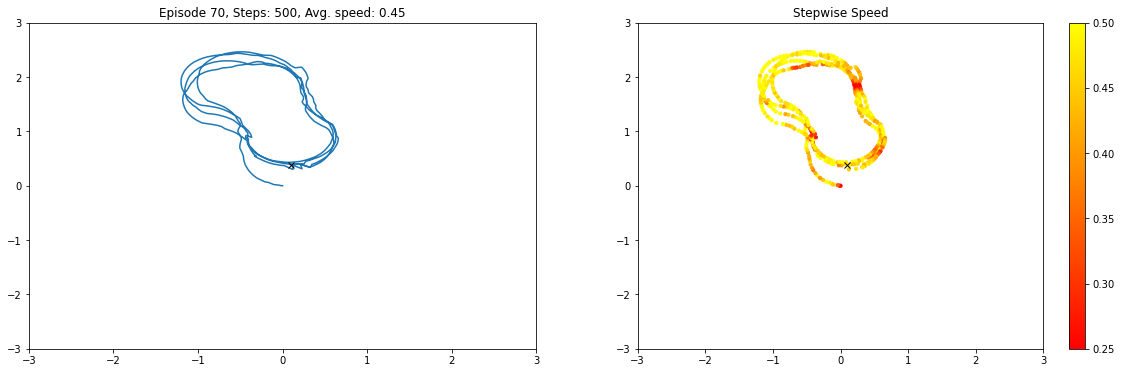

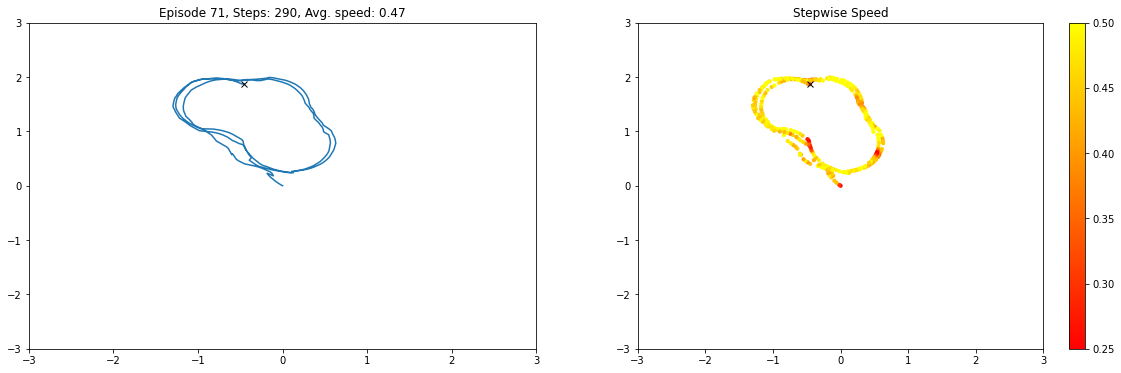

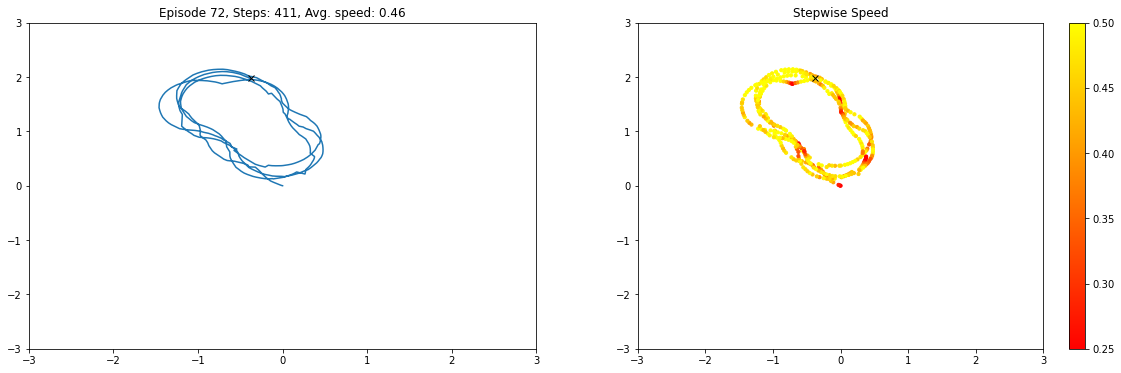

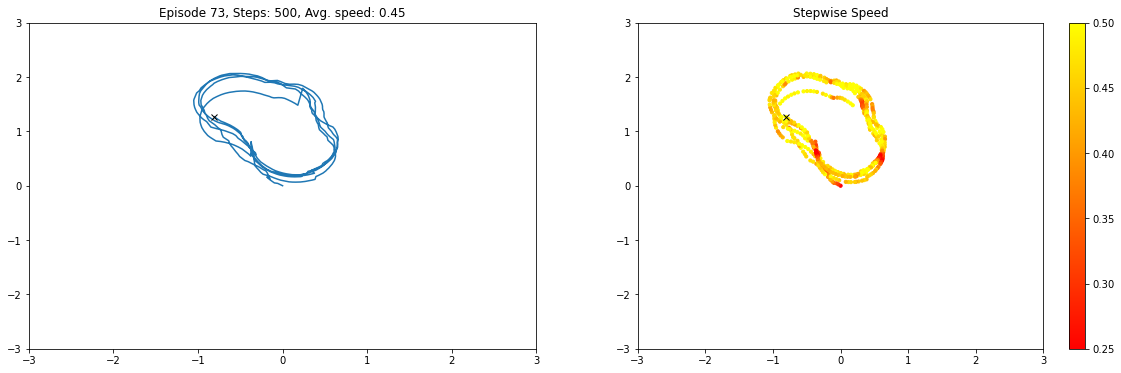

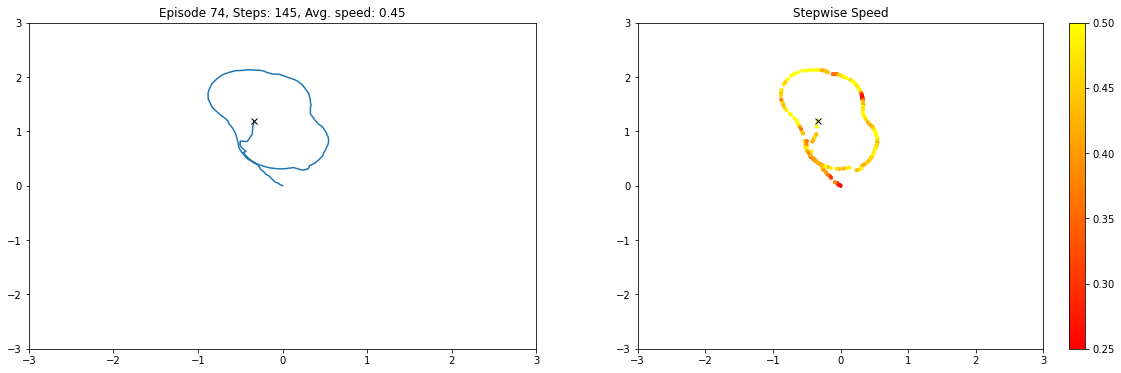

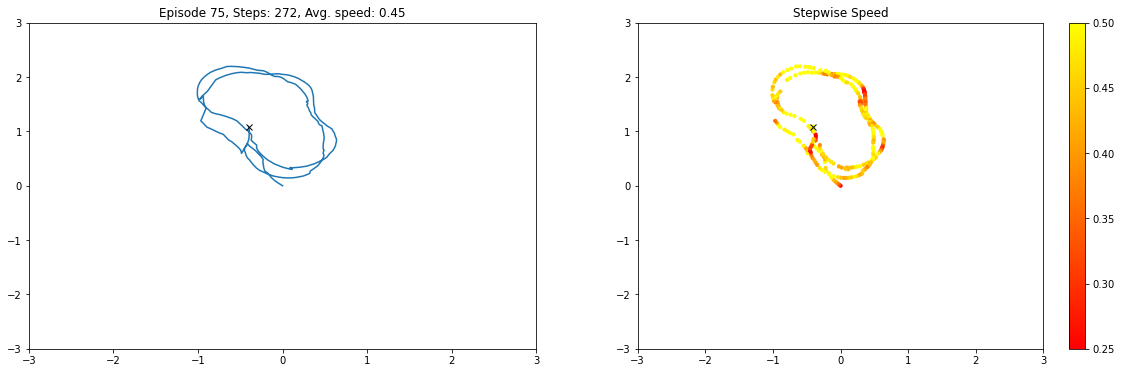

In [293]:
e = 72
for e in range(data.Episode.max()):
    plt.figure(1, (20, 6))
    episode = data[data.Episode == e]
    x = episode["PosX"].values[5:]
    z = episode["PosZ"].values[5:]
    
    plt.subplot(1, 2, 1)
    plt.plot(x - x[0], z - z[0])
    plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
    steps = len(x) + 5
    average_speed = episode.Speed[10:].mean()
    plt.title("Episode {}, Steps: {}, Avg. speed: {:.2f}".format(e + 1, steps, average_speed))
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    
    plt.subplot(1, 2, 2)
    plt.title("Stepwise Speed")
    plt.scatter(x - x[0], z - z[0], c=episode.Speed[5:], cmap = plt.cm.autumn, s=10)
    plt.plot(x[-1] - x[0], z[-1] - z[0], marker="x", color="k")
    plt.clim(0.25, 0.5)
    plt.colorbar()
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    
    #plt.title("Drift in position over time", size = 14)
    plt.show()